# Loyola Supply Chain Data Analysis Competition

## Contributers:

    Aarij Rehman
    Charlie Marshall

## Loading Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

## Loading in Data (Charlie):

Aarij will have to use different directories for his data.

In [2]:
FreightWaves=pd.read_excel("/Users/charlesmarshall/Desktop/Loyola-Supply-Chain-Competition/FreightWaves External Data.xlsx")

In [3]:
ShipperData=pd.read_excel("/Users/charlesmarshall/Desktop/Loyola-Supply-Chain-Competition/Loyola 2nd Annual Data Competition - Shipper Data Set (Trailing 2-Years).xlsx")

In [4]:
#FreightWaves=pd.read_excel("/Users/aarij/Desktop/python-projects/loyola-supply-chain/FreightWaves External Data.xlsx")

In [5]:
#ShipperData=pd.read_excel("/Users/aarij/Desktop/python-projects/loyola-supply-chain/Loyola 2nd Annual Data Competition - Shipper Data Set (Trailing 2-Years).xlsx")

In [6]:
ShipperData.head()

Load Number  Book Date Pickup Date Delivery Date Origin Market  \
0         1046 2018-02-26  2018-02-26    2018-02-27       Atlanta   
1         1223 2018-02-15  2018-02-16    2018-02-18       Chicago   
2         1280 2018-02-15  2018-02-15    2018-02-19   Los Angeles   
3         1282 2018-02-15  2018-02-16    2018-02-20       Chicago   
4         1340 2018-02-16  2018-02-19    2018-02-19       Chicago   

   3-Digit Origin # Origin State Dest Market 3-Digit Dest # Dest State  \
0               300           GA         NaN            217         MD   
1               463           IN         NaN            820         WY   
2               906           CA         NaN            554         MN   
3               601           IL     Chicago            606         IL   
4               606           IL     Chicago            607         IL   

           Mode Mileage Spot/Contract  Revenue  Accessorial Cost  Load Type  
0  Temp Control    1316          Spot  1650.00                 0     Ad-hoc  
1  Temp Control    1920          Spot  3480.00                 0     Ad-hoc  
2       Dry Van    3816          Spot  3567.80                 0     Ad-hoc  
3       Dry Van      48          Spot   203.35               -42     Ad-hoc  
4       Dry Van      42          Spot   343.88                 0  Dedicated

## EDA

Understanding the data:

In [7]:
ShipperData['Book Date']=pd.to_datetime(ShipperData['Book Date'])
ShipperData['Pickup Date']=pd.to_datetime(ShipperData['Pickup Date'])
ShipperData['Delivery Date']=pd.to_datetime(ShipperData['Delivery Date'])

In [8]:
set(ShipperData['Origin Market'])

{'Atlanta', 'Chicago', 'Dallas', 'Los Angeles', 'Philadelphia', 'Seattle'}

In [9]:
set(ShipperData['Mode'])

{'Air',
 'Drayage',
 'Dry Van',
 'FlatBed',
 'Intermodal',
 'Ocean',
 'Other',
 'Reefer',
 'Temp Control',
 'Truck'}

In [10]:
set(ShipperData['Spot/Contract'])

{'Contract', 'Spot'}

In [11]:
set(ShipperData['Load Type'])

{'Ad-hoc', 'Consistent', 'Critical', 'Dedicated', 'Standard', 'White Glove'}

In [12]:
set(FreightWaves['index_name'])

{'DAT Longhaul Van Freight Rate',
 'Diesel Truck Stop Actual Price Per Gallon',
 'Headhaul Index',
 'Industrial Production',
 'Institute of Supply Management Metrics',
 'Intermodal Rates',
 'Orders',
 "Outbound Rail Volume 53' Containers (Loaded)",
 'Outbound Tender Reject Index',
 'Outbound Tender Volume Index',
 'Producer Price Index',
 'Retail Sales YoY Change',
 'TLT is now a legacy variable, refer to OTLT',
 'Total Construction Spending (000,000s)',
 'US Customs Maritime Import Shipments'}

## Preprocessing

Some preproccessing that needs to be done to the whole data set

### 7 FreightWaves Futures Lanes:
    VLS (LA -> Seattle)
    VSL (Seattle -> LA)
    VLD (LA -> Dallas)
    VDL (Dallas -> LA)
    VCA (Chicago -> Atlanta)
    VAP (Atlanta -> Philadelphia)
    VPC (Philadelphia -> Chicago)
    
    If the load is not delivered in one of these lanes, it will be marked 'Other'

In [13]:
# Categorizing the Future Lanes
Lane = []
org = list(ShipperData['Origin Market'])
dst = list(ShipperData['Dest Market'])
los = 'Los Angeles'
sea = 'Seattle'
dal = 'Dallas'
chi = 'Chicago'
atl = 'Atlanta'
phi = 'Philadelphia'

futures = {}
futures[(los, sea)] = 'VLS'
futures[(sea, los)] = 'VSL'
futures[(los, dal)] = 'VLD'
futures[(dal, los)] = 'VDL'
futures[(chi, atl)] = 'VCA'
futures[(atl, phi)] = 'VAP'
futures[(phi, chi)] = 'VPC'

In [14]:
Lane=[]
for i in range(len(org)):
    if (org[i], dst[i]) in futures:
        Lane.append(futures[(org[i], dst[i])])
    else:
        Lane.append('Other')

In [15]:
ShipperData['Lane'] = Lane

In [16]:
ShipperData.head()

Load Number  Book Date Pickup Date Delivery Date Origin Market  \
0         1046 2018-02-26  2018-02-26    2018-02-27       Atlanta   
1         1223 2018-02-15  2018-02-16    2018-02-18       Chicago   
2         1280 2018-02-15  2018-02-15    2018-02-19   Los Angeles   
3         1282 2018-02-15  2018-02-16    2018-02-20       Chicago   
4         1340 2018-02-16  2018-02-19    2018-02-19       Chicago   

   3-Digit Origin # Origin State Dest Market 3-Digit Dest # Dest State  \
0               300           GA         NaN            217         MD   
1               463           IN         NaN            820         WY   
2               906           CA         NaN            554         MN   
3               601           IL     Chicago            606         IL   
4               606           IL     Chicago            607         IL   

           Mode Mileage Spot/Contract  Revenue  Accessorial Cost  Load Type  \
0  Temp Control    1316          Spot  1650.00                 0     Ad-hoc   
1  Temp Control    1920          Spot  3480.00                 0     Ad-hoc   
2       Dry Van    3816          Spot  3567.80                 0     Ad-hoc   
3       Dry Van      48          Spot   203.35               -42     Ad-hoc   
4       Dry Van      42          Spot   343.88                 0  Dedicated   

    Lane  
0  Other  
1  Other  
2  Other  
3  Other  
4  Other

### Rate per Mile

    Calculating the Rate per Mile (RPM) for all loads

In [17]:
rpm=np.empty(len(ShipperData))

In [18]:
for i in range(len(ShipperData)):
    if ShipperData['Mileage'][i]==0 or ShipperData['Revenue'][i]==0:
        rpm[i]=np.nan
    else:
        try:
            rpm[i]= ShipperData['Revenue'][i]/ShipperData['Mileage'][i]
        except TypeError:
            rpm[i]=np.nan

In [19]:
ShipperData['RPM'] = rpm

In [20]:
ShipperData=ShipperData.dropna(subset=['RPM'])

## Questions to Ask:

#### Part 1    
    1) Does 2019 mean the book, pickup, or delivery date is in 2019? There are many times when the one of these three meaures are in another year while other measures are in 2019.
    - Something to think about: when the deal is booked is when the rate is agreed, so it might be more appropriate to do year by book date.
    2) When you say "Truckload" RPM", does this mean only for trucks and dry vans?
    3) How should we deal with instances where the mileage is 0 or blank? Outlier
    4) How would you define "volatility"? Does it have something to do with spot vs contract market prices and how they change? Maybe the spread of the prices?

## Question 1

    Calculating overall average Truckload rate per mile in 2019?  Hint: rate per mile is total revenue for a move divided by total mileage.  Please also note that “Dry Van” and “Truck” mean the same thing here:

    Steps:
    Year = 2019
    Truckload = "Dry Van" or "Truck" in Mode ??? NOT SURE IF "TRUCKLOAD" MEANS JUST THESE TWO ANYMORE ???
    Create column of Rate per mile (RPM), divide revenue by mileage for each truckload
    Sum the RPM column, divide by number of instances to find AVERAGE
    

### Converting all date columns to datetime

In [21]:
Shipper2019=ShipperData[ShipperData['Pickup Date'].dt.year == 2019]

In [22]:
Shipper2019.head()

Load Number  Book Date Pickup Date Delivery Date Origin Market  \
2492       147769 2018-12-31  2019-01-02    2019-01-04       Atlanta   
2532       147889 2018-12-19  2019-01-02    2019-01-11   Los Angeles   
2588       155164 2019-01-03  2019-01-05    2019-01-07       Chicago   
2589       155166 2019-01-08  2019-01-08    2019-01-10       Chicago   
2590       155169 2019-01-03  2019-01-05    2019-01-07       Chicago   

      3-Digit Origin # Origin State Dest Market 3-Digit Dest # Dest State  \
2492               310           GA         NaN            782         TX   
2532               902           CA         NaN            482         MI   
2588               609           IL         NaN            404         KY   
2589               606           IL         NaN            154         MA   
2590               609           IL         NaN            404         KY   

            Mode Mileage Spot/Contract  Revenue  Accessorial Cost   Load Type  \
2492     Dry Van    2218          Spot  1836.00                 0      Ad-hoc   
2532  Intermodal    4600          Spot  4340.00                 0      Ad-hoc   
2588     Dry Van     764          Spot  1266.34                 0  Consistent   
2589     Dry Van    1898          Spot  2895.15               -11      Ad-hoc   
2590     Dry Van     764          Spot  1266.34                 0  Consistent   

       Lane       RPM  
2492  Other  0.827773  
2532  Other  0.943478  
2588  Other  1.657513  
2589  Other  1.525369  
2590  Other  1.657513

In [23]:
Q1=Shipper2019[Shipper2019['Mode'].isin(['Dry Van','Truck'])].copy()

In [24]:
Q1=Q1.reset_index(drop=True)

In [25]:
Q1[Q1['Mileage']==0].head()

Empty DataFrame
Columns: [Load Number, Book Date, Pickup Date, Delivery Date, Origin Market, 3-Digit Origin #, Origin State, Dest Market, 3-Digit Dest #, Dest State, Mode, Mileage, Spot/Contract, Revenue, Accessorial Cost, Load Type, Lane, RPM]
Index: []

In [26]:
Q1[Q1['Revenue']==0].head()

Empty DataFrame
Columns: [Load Number, Book Date, Pickup Date, Delivery Date, Origin Market, 3-Digit Origin #, Origin State, Dest Market, 3-Digit Dest #, Dest State, Mode, Mileage, Spot/Contract, Revenue, Accessorial Cost, Load Type, Lane, RPM]
Index: []

In [27]:
Average2019RPM=sum(Q1['RPM'])/len(Q1)

In [28]:
Average2019RPM

3.6833165330179947

### Question 1a

    Using this Redwood rate per mile data, rank the 7 FreightWaves Futures lanes (page 2 at link) by rate volatility for full year 2019.
    
    Volatility = sd
    So, the Futures lanes will be ranked by sd of RPM data. Highest to lowest.

In [29]:
LaneVolitility2019=pd.DataFrame(Q1.groupby('Lane')['RPM'].std(),columns=['RPM']).drop(['Other']).sort_values(by=['RPM'],ascending=False)

In [30]:
LaneVolitility2019

RPM
Lane          
VPC   5.410751
VCA   1.269197
VLS   0.789660
VAP   0.625256
VLD   0.552769
VDL   0.357352
VSL   0.296679

### Question 1b

    Rank these lanes by total Redwood Truckload volume for full year 2019.
    
    Defining "volume" as the number (count) of truckloads delivered in each lane in 2019.

In [31]:
LaneVolume2019=pd.DataFrame(Q1.groupby('Lane')['RPM'].count()).drop(['Other']).sort_values(by=['RPM'],ascending=False).rename(columns={'RPM':'Volume'})

In [32]:
LaneVolume2019

Volume
Lane        
VCA      394
VSL      275
VDL      198
VPC      197
VLS      174
VLD      107
VAP       40

In [33]:
Shipper2019['Lane'].value_counts()

Other    47750
VCA        478
VSL        291
VDL        258
VPC        230
VLS        187
VLD        136
VAP         42
Name: Lane, dtype: int64

## Question 2

    Rank the lanes provided in the FreightWaves data by total intermodal volume for full year 2019.

In [34]:
Q2=Shipper2019[Shipper2019['Mode'].isin(['Intermodal'])]

In [35]:
Q2=Q2.reset_index(drop=True)

In [36]:
IntermodalLaneVolume2019=pd.DataFrame(Q2.groupby('Lane')['Load Number'].count()).drop(['Other']).sort_values(by=['Load Number'],ascending=False).rename(columns={'RPM':'Volume'})

In [37]:
IntermodalLaneVolume2019

Load Number
Lane             
VDL            47
VLD            29
VCA             1

## Question 3

    Graph monthly volatility in fuel prices by markets provided in the FreightWaves data.  Do any markets stand out to you in particular?

In [38]:
FreightWaves['data_timestamp']=pd.to_datetime(FreightWaves['data_timestamp'])

In [39]:
FreightWaves.head()

ticker granularity1    symbol data_timestamp  data_value  \
0   COSP          RES  COSP.RES     2019-04-30    512113.0   
1   COSP          RES  COSP.RES     2019-09-30    529455.0   
2   COSP          RES  COSP.RES     2019-11-30    540457.0   
3   COSP          RES  COSP.RES     2018-02-28    577315.0   
4   COSP          RES  COSP.RES     2018-12-31    517951.0   

                               index_name  Description  
0  Total Construction Spending (000,000s)  Residential  
1  Total Construction Spending (000,000s)  Residential  
2  Total Construction Spending (000,000s)  Residential  
3  Total Construction Spending (000,000s)  Residential  
4  Total Construction Spending (000,000s)  Residential

In [40]:
set(FreightWaves['ticker'])

{'COSP',
 'CSTM',
 'DATVF',
 'DTS',
 'HAUL',
 'INTRM',
 'IPRO',
 'ISM',
 'ORAIL53L',
 'ORDERS',
 'OTRI',
 'OTVI',
 'PPI',
 'RESLG',
 'TLT'}

In [41]:
Q3=FreightWaves[FreightWaves['ticker']=='DTS']

In [42]:
Q3=Q3.reset_index(drop=True)

In [43]:
Q3.head()

ticker granularity1   symbol data_timestamp  data_value  \
0    DTS          ATL  DTS.ATL     2018-03-13       2.777   
1    DTS          ATL  DTS.ATL     2018-03-16       2.828   
2    DTS          ATL  DTS.ATL     2018-03-27       2.921   
3    DTS          ATL  DTS.ATL     2018-03-29       2.952   
4    DTS          ATL  DTS.ATL     2018-04-02       2.915   

                                  index_name  Description  
0  Diesel Truck Stop Actual Price Per Gallon  Atlanta, GA  
1  Diesel Truck Stop Actual Price Per Gallon  Atlanta, GA  
2  Diesel Truck Stop Actual Price Per Gallon  Atlanta, GA  
3  Diesel Truck Stop Actual Price Per Gallon  Atlanta, GA  
4  Diesel Truck Stop Actual Price Per Gallon  Atlanta, GA

In [44]:
set(Q3['Description'])

{'Atlanta, GA',
 'Chicago, IL',
 'Dallas, TX',
 'Los Angeles, CA',
 'Philadelphia, PA',
 'Seattle, WA'}

In [45]:
set(Q3['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [46]:
per = Q3.data_timestamp.dt.to_period("M")

In [47]:
DTS_Monthly_Volatility=Q3.groupby(['granularity1',per]).std()

In [48]:
DTS_Monthly_Volatility.head()

data_value
granularity1 data_timestamp            
ATL          2018-03           0.061742
             2018-04           0.047529
             2018-05           0.043612
             2018-06           0.053354
             2018-07           0.021432

In [49]:
months=['2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01','2020-02']
y_atl=DTS_Monthly_Volatility['data_value'][0:24]
y_chi=DTS_Monthly_Volatility['data_value'][24:48]
y_dal=DTS_Monthly_Volatility['data_value'][48:72]
y_lax=DTS_Monthly_Volatility['data_value'][72:96]
y_phl=DTS_Monthly_Volatility['data_value'][96:120]
y_sea=DTS_Monthly_Volatility['data_value'][120:144]

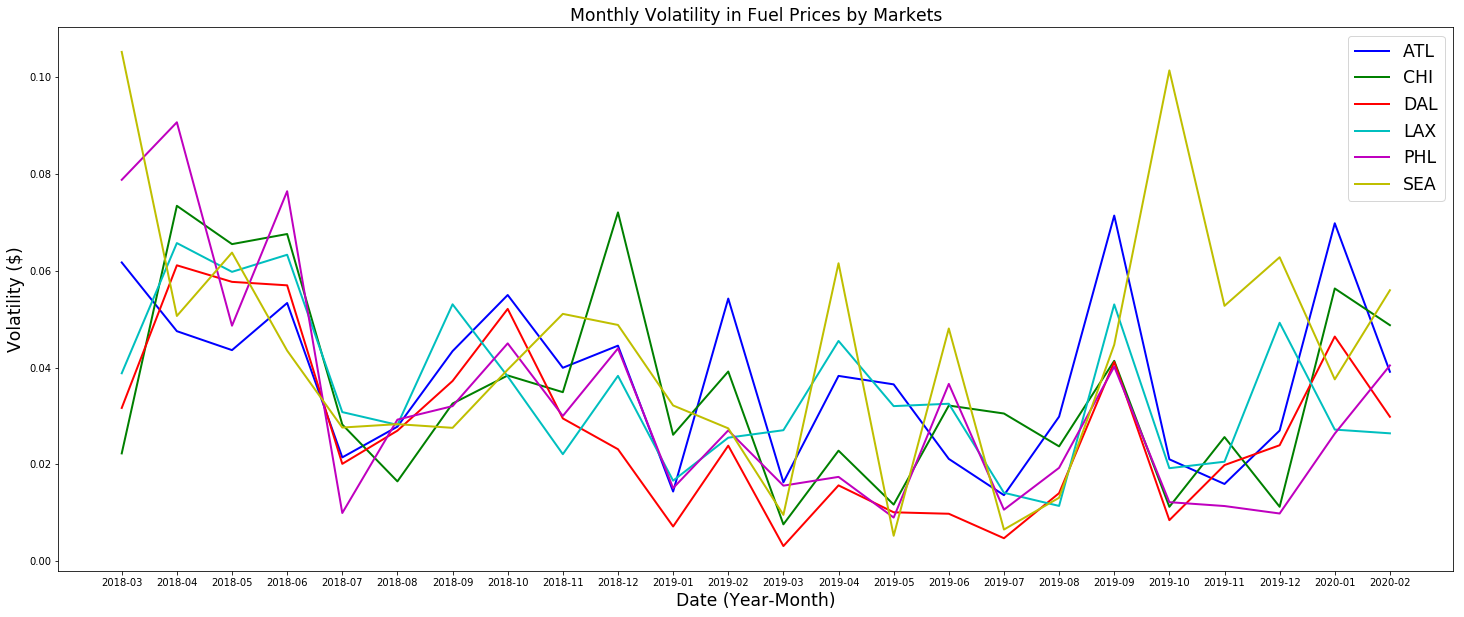

In [50]:
fig1 = plt.figure(figsize=(25,10))
plt.plot( months, y_atl, marker='', color='b', linewidth=2,label="ATL")
plt.plot( months, y_chi, marker='', color='g', linewidth=2,label="CHI")
plt.plot( months, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot( months, y_lax, marker='', color='c', linewidth=2,label="LAX")
plt.plot( months, y_phl, marker='', color='m', linewidth=2,label="PHL")
plt.plot( months, y_sea, marker='', color='y', linewidth=2,label="SEA")
plt.title('Monthly Volatility in Fuel Prices by Markets',fontsize='xx-large')
plt.ylabel('Volatility ($)',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')
plt.legend(fontsize='xx-large')

## Question 4

    Briefly explain how the mixture of spot and contract (% of total volume) of Dry-Van freight in the Redwood Data varied throughout 2018-2019.  What factors do you think would cause a shipper to sign a forward-looking Truckload rate contract or rely on the spot market?

In [51]:
Shipper2019 = ShipperData[(ShipperData['Pickup Date'].dt.year == 2019) & (ShipperData['Mode'].isin(['Dry Van', 'Truck']))]
Shipper2018 = ShipperData[(ShipperData['Pickup Date'].dt.year == 2018) & (ShipperData['Mode'].isin(['Dry Van', 'Truck']))]

In [52]:
spot18 = []
spot19 = []
for month in range(1, 13):
    spot18.append(Shipper2018[Shipper2018['Pickup Date'].dt.month == month]['Spot/Contract'].value_counts(normalize=True)['Spot'])
    spot19.append(Shipper2019[Shipper2019['Pickup Date'].dt.month == month]['Spot/Contract'].value_counts(normalize=True)['Spot'])
spot = spot18 + spot19

In [53]:
cont = [1-i for i in spot]

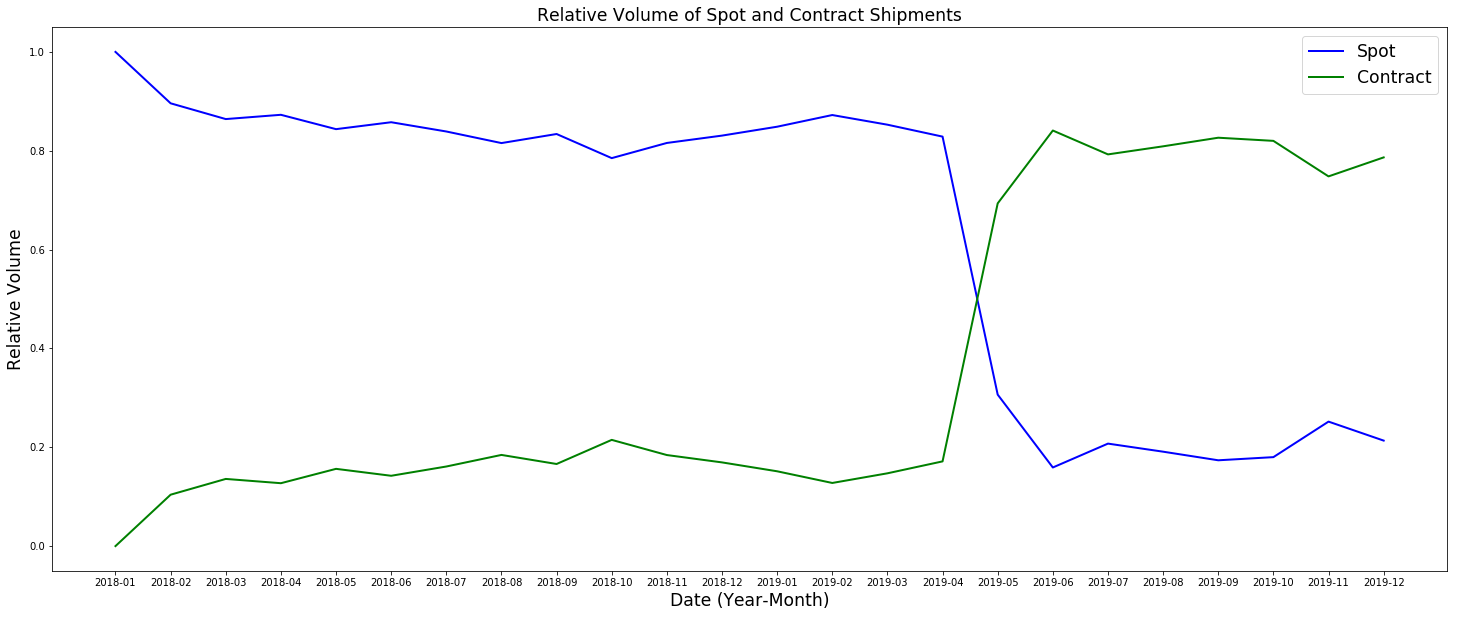

In [54]:
months=['2018-01', '2018-02', '2018-03', '2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig = plt.figure(figsize=(25,10))
plt.plot(months, spot, marker='', color='b', linewidth=2,label="Spot")
plt.plot(months, cont, marker='', color='g', linewidth=2,label="Contract")

plt.title('Relative Volume of Spot and Contract Shipments',fontsize='xx-large')
plt.ylabel('Relative Volume',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')
plt.legend(fontsize='xx-large')

## Question 5

    Based on initial analysis, please list and explain the (3) “external factors” from the FreightWaves data you think look the most promising for predicting 2020 dry van shipper rates as a Shipper.  

In [55]:
Q5=ShipperData[ShipperData['Mode'].isin(['Dry Van','Truck'])]

In [56]:
Q5=Q5.reset_index(drop=True)

In [57]:
Q5.head()

Load Number  Book Date Pickup Date Delivery Date Origin Market  \
0         1280 2018-02-15  2018-02-15    2018-02-19   Los Angeles   
1         1282 2018-02-15  2018-02-16    2018-02-20       Chicago   
2         1340 2018-02-16  2018-02-19    2018-02-19       Chicago   
3         1397 2018-02-19  2018-02-22    2018-02-22        Dallas   
4         1398 2018-02-21  2018-02-22    2018-02-22        Dallas   

   3-Digit Origin # Origin State Dest Market 3-Digit Dest # Dest State  \
0               906           CA         NaN            554         MN   
1               601           IL     Chicago            606         IL   
2               606           IL     Chicago            607         IL   
3               761           TX      Dallas            761         TX   
4               761           TX      Dallas            761         TX   

      Mode Mileage Spot/Contract  Revenue  Accessorial Cost   Load Type  \
0  Dry Van    3816          Spot  3567.80                 0      Ad-hoc   
1  Dry Van      48          Spot   203.35               -42      Ad-hoc   
2  Dry Van      42          Spot   343.88                 0   Dedicated   
3  Dry Van      60          Spot   311.47                 0  Consistent   
4  Dry Van      60          Spot   311.47                 0      Ad-hoc   

    Lane       RPM  
0  Other  0.934958  
1  Other  4.236458  
2  Other  8.187619  
3  Other  5.191167  
4  Other  5.191167

In [58]:
FreightWaves.head()

ticker granularity1    symbol data_timestamp  data_value  \
0   COSP          RES  COSP.RES     2019-04-30    512113.0   
1   COSP          RES  COSP.RES     2019-09-30    529455.0   
2   COSP          RES  COSP.RES     2019-11-30    540457.0   
3   COSP          RES  COSP.RES     2018-02-28    577315.0   
4   COSP          RES  COSP.RES     2018-12-31    517951.0   

                               index_name  Description  
0  Total Construction Spending (000,000s)  Residential  
1  Total Construction Spending (000,000s)  Residential  
2  Total Construction Spending (000,000s)  Residential  
3  Total Construction Spending (000,000s)  Residential  
4  Total Construction Spending (000,000s)  Residential

### Feature Engineering

    Task is to find the features in the Freight Waves data that are best at predicting RPM in 2020. The tricky part is how to represent each of these features.

### Potential Features:

    1) Past "performance" of indecies
        - past month should be used because it is improper to use future data to predict current performance. For instance, you can use a current monthly average to train the data on, but when predicting on future data, there will be no way to calculate the average for a current month because the month is not yet over.
        - what period of time is relevant? this most likely changes based on the index but multiple time periods should be explored.
    2) Comparing Y2Y rates might also be smart.

### EDA

Exploring each of the indecies to better understand them and how they should be utilized in a model.

In [59]:
set(FreightWaves['index_name'])

{'DAT Longhaul Van Freight Rate',
 'Diesel Truck Stop Actual Price Per Gallon',
 'Headhaul Index',
 'Industrial Production',
 'Institute of Supply Management Metrics',
 'Intermodal Rates',
 'Orders',
 "Outbound Rail Volume 53' Containers (Loaded)",
 'Outbound Tender Reject Index',
 'Outbound Tender Volume Index',
 'Producer Price Index',
 'Retail Sales YoY Change',
 'TLT is now a legacy variable, refer to OTLT',
 'Total Construction Spending (000,000s)',
 'US Customs Maritime Import Shipments'}

In [60]:
set(FreightWaves['ticker'])

{'COSP',
 'CSTM',
 'DATVF',
 'DTS',
 'HAUL',
 'INTRM',
 'IPRO',
 'ISM',
 'ORAIL53L',
 'ORDERS',
 'OTRI',
 'OTVI',
 'PPI',
 'RESLG',
 'TLT'}

### COSP

In [61]:
COSP=FreightWaves[FreightWaves['ticker']=='COSP']

In [62]:
COSP=COSP.sort_values(by='data_timestamp').reset_index(drop=True)

In [63]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig2 = plt.figure(figsize=(25,10))
plt.plot(months, COSP['data_value'], marker='o', color='b', linewidth=2)
plt.title('Monthly Total Construction Spending',fontsize='xx-large')
plt.ylabel('Total Construction Spending ($)',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month)')

### CSTM

In [64]:
CSTM=FreightWaves[FreightWaves['ticker']=='CSTM']

In [65]:
set(CSTM['granularity1'])

{'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [66]:
CSTM_value=CSTM.groupby(['granularity1','data_timestamp']).mean()

In [67]:
CSTM_value = CSTM_value.reset_index()

In [68]:
cstm_chi=list(CSTM_value[CSTM_value['granularity1']=='CHI']['data_timestamp'])
cstm_dal=list(CSTM_value[CSTM_value['granularity1']=='DAL']['data_timestamp'])
cstm_lax=list(CSTM_value[CSTM_value['granularity1']=='LAX']['data_timestamp'])
cstm_phl=list(CSTM_value[CSTM_value['granularity1']=='PHL']['data_timestamp'])
cstm_sea=list(CSTM_value[CSTM_value['granularity1']=='SEA']['data_timestamp'])

In [69]:
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(cstm_chi)):
    x_chi.append(cstm_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(cstm_dal)):
    x_dal.append(cstm_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(cstm_lax)):
    x_lax.append(cstm_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(cstm_phl)):
    x_phl.append(cstm_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(cstm_sea)):
    x_sea.append(cstm_sea[i].strftime('%Y-%m-%d'))

In [70]:
y_chi=CSTM_value[CSTM_value['granularity1']=='CHI']['data_value']
y_dal=CSTM_value[CSTM_value['granularity1']=='DAL']['data_value']
y_lax=CSTM_value[CSTM_value['granularity1']=='LAX']['data_value']
y_phl=CSTM_value[CSTM_value['granularity1']=='PHL']['data_value']
y_sea=CSTM_value[CSTM_value['granularity1']=='SEA']['data_value']

In [71]:
fig3 = plt.figure(figsize=(25,10))
plt.plot(x_chi, y_chi, marker='', color='g', linewidth=2,label="CHI")
plt.title('US Customs Maritime Import Shipments Time Series for CHI',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month-Day)')

In [72]:
fig4 = plt.figure(figsize=(25,10))
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.title('US Customs Maritime Import Shipments Time Series for DAL',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month-Day)')

In [73]:
fig5 = plt.figure(figsize=(25,10))
plt.plot(x_lax, y_lax, marker='', color='c', linewidth=2,label="LAX")
plt.title('US Customs Maritime Import Shipments Time Series for LAX',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month-Day)')

In [74]:
fig6 = plt.figure(figsize=(25,10))
plt.plot(x_phl, y_phl, marker='', color='m', linewidth=2,label="PHL")
plt.title('US Customs Maritime Import Shipments Time Series for PHL',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month-Day)')

In [75]:
fig7 = plt.figure(figsize=(25,10))
plt.plot(x_sea, y_sea, marker='', color='y', linewidth=2,label="SEA")
plt.title('US Customs Maritime Import Shipments Time Series for SEA',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month-Day)')

### DATVF

In [76]:
DATVF=FreightWaves[FreightWaves['ticker']=='DATVF']

In [77]:
set(DATVF['granularity1'])

{'ATLPHL', 'CHIATL', 'DALLAX', 'LAXDAL', 'LAXSEA', 'PHLCHI', 'SEALAX'}

In [78]:
#per = DATVF.data_timestamp.dt.to_period("D")

In [79]:
DATVF_value=DATVF.groupby(['granularity1','data_timestamp']).mean()

In [80]:
DATVF_value=DATVF_value.reset_index()

In [81]:
datvf_vap=list(DATVF_value[DATVF_value['granularity1']=='ATLPHL']['data_timestamp'])
datvf_vca=list(DATVF_value[DATVF_value['granularity1']=='CHIATL']['data_timestamp'])
datvf_vdl=list(DATVF_value[DATVF_value['granularity1']=='DALLAX']['data_timestamp'])
datvf_vld=list(DATVF_value[DATVF_value['granularity1']=='LAXDAL']['data_timestamp'])
datvf_vls=list(DATVF_value[DATVF_value['granularity1']=='LAXSEA']['data_timestamp'])
datvf_vpc=list(DATVF_value[DATVF_value['granularity1']=='PHLCHI']['data_timestamp'])
datvf_vsl=list(DATVF_value[DATVF_value['granularity1']=='SEALAX']['data_timestamp'])

In [82]:
x_vap=[]
x_vca=[]
x_vdl=[]
x_vld=[]
x_vls=[]
x_vpc=[]
x_vsl=[]

for i in range(len(datvf_vap)):
    x_vap.append(datvf_vap[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vca)):
    x_vca.append(datvf_vca[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vdl)):
    x_vdl.append(datvf_vdl[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vld)):
    x_vld.append(datvf_vld[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vls)):
    x_vls.append(datvf_vls[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vpc)):
    x_vpc.append(datvf_vpc[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vsl)):
    x_vsl.append(datvf_vsl[i].strftime('%Y-%m-%d'))

In [83]:
y_vap=DATVF_value[DATVF_value['granularity1']=='ATLPHL']['data_value']
y_vca=DATVF_value[DATVF_value['granularity1']=='CHIATL']['data_value']
y_vdl=DATVF_value[DATVF_value['granularity1']=='DALLAX']['data_value']
y_vld=DATVF_value[DATVF_value['granularity1']=='LAXDAL']['data_value']
y_vls=DATVF_value[DATVF_value['granularity1']=='LAXSEA']['data_value']
y_vpc=DATVF_value[DATVF_value['granularity1']=='PHLCHI']['data_value']
y_vsl=DATVF_value[DATVF_value['granularity1']=='SEALAX']['data_value']

In [84]:
fig8 = plt.figure(figsize=(25,10))
plt.plot(x_vap, y_vap, marker='', color='g', linewidth=2,label="ATLPHL")
plt.plot(x_vca, y_vca, marker='', color='r', linewidth=2,label="CHIATL")
plt.plot(x_vdl, y_vdl, marker='', color='b', linewidth=2,label="DALLAX")
plt.plot(x_vld, y_vld, marker='', color='y', linewidth=2,label="LAXDAL")
plt.plot(x_vls, y_vls, marker='', color='c', linewidth=2,label="LAXSEA")
plt.plot(x_vpc, y_vpc, marker='', color='m', linewidth=2,label="PHLCHI")
plt.plot(x_vsl, y_vsl, marker='', color='k', linewidth=2,label="SEALAX")
plt.title('DAT Longhaul Van Freight Rates Time Series',fontsize='xx-large')
plt.ylabel('DAT Longhaul Van Freight Rate',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### DTS

In [85]:
DTS=FreightWaves[FreightWaves['ticker']=='DTS']

In [86]:
set(DTS['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [87]:
#per = DTS.data_timestamp.dt.to_period("D")

In [88]:
DTS_value=DTS.groupby(['granularity1','data_timestamp']).mean()

In [89]:
DTS_value=DTS_value.reset_index()

In [90]:
dts_atl=list(DTS_value[DTS_value['granularity1']=='ATL']['data_timestamp'])
dts_chi=list(DTS_value[DTS_value['granularity1']=='CHI']['data_timestamp'])
dts_dal=list(DTS_value[DTS_value['granularity1']=='DAL']['data_timestamp'])
dts_lax=list(DTS_value[DTS_value['granularity1']=='LAX']['data_timestamp'])
dts_phl=list(DTS_value[DTS_value['granularity1']=='PHL']['data_timestamp'])
dts_sea=list(DTS_value[DTS_value['granularity1']=='SEA']['data_timestamp'])

In [91]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(dts_atl)):
    x_atl.append(dts_atl[i].strftime('%Y-%m-%d'))

for i in range(len(dts_chi)):
    x_chi.append(dts_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(dts_dal)):
    x_dal.append(dts_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(dts_lax)):
    x_lax.append(dts_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(dts_phl)):
    x_phl.append(dts_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(dts_sea)):
    x_sea.append(dts_sea[i].strftime('%Y-%m-%d'))

In [92]:
y_atl=DTS_value[DTS_value['granularity1']=='ATL']['data_value']
y_chi=DTS_value[DTS_value['granularity1']=='CHI']['data_value']
y_dal=DTS_value[DTS_value['granularity1']=='DAL']['data_value']
y_lax=DTS_value[DTS_value['granularity1']=='LAX']['data_value']
y_phl=DTS_value[DTS_value['granularity1']=='PHL']['data_value']
y_sea=DTS_value[DTS_value['granularity1']=='SEA']['data_value']

In [93]:
fig9 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Diesel Truck Stop Actual Price Per Gallon Time Series',fontsize='xx-large')
plt.ylabel('Diesel Truck Stop Actual Price Per Gallon',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### HAUL

In [94]:
HAUL=FreightWaves[FreightWaves['ticker']=='HAUL']

In [95]:
set(HAUL['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [96]:
#per = HAUL.data_timestamp.dt.to_period("D")

In [97]:
HAUL_value=HAUL.groupby(['granularity1','data_timestamp']).mean()

In [98]:
HAUL_value=HAUL_value.reset_index()

In [99]:
haul_atl=list(HAUL_value[HAUL_value['granularity1']=='ATL']['data_timestamp'])
haul_chi=list(HAUL_value[HAUL_value['granularity1']=='CHI']['data_timestamp'])
haul_dal=list(HAUL_value[HAUL_value['granularity1']=='DAL']['data_timestamp'])
haul_lax=list(HAUL_value[HAUL_value['granularity1']=='LAX']['data_timestamp'])
haul_phl=list(HAUL_value[HAUL_value['granularity1']=='PHL']['data_timestamp'])
haul_sea=list(HAUL_value[HAUL_value['granularity1']=='SEA']['data_timestamp'])

In [100]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(haul_atl)):
    x_atl.append(haul_atl[i].strftime('%Y-%m-%d'))

for i in range(len(haul_chi)):
    x_chi.append(haul_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(haul_dal)):
    x_dal.append(haul_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(haul_lax)):
    x_lax.append(haul_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(haul_phl)):
    x_phl.append(haul_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(haul_sea)):
    x_sea.append(haul_sea[i].strftime('%Y-%m-%d'))

In [101]:
y_atl=HAUL_value[HAUL_value['granularity1']=='ATL']['data_value']
y_chi=HAUL_value[HAUL_value['granularity1']=='CHI']['data_value']
y_dal=HAUL_value[HAUL_value['granularity1']=='DAL']['data_value']
y_lax=HAUL_value[HAUL_value['granularity1']=='LAX']['data_value']
y_phl=HAUL_value[HAUL_value['granularity1']=='PHL']['data_value']
y_sea=HAUL_value[HAUL_value['granularity1']=='SEA']['data_value']

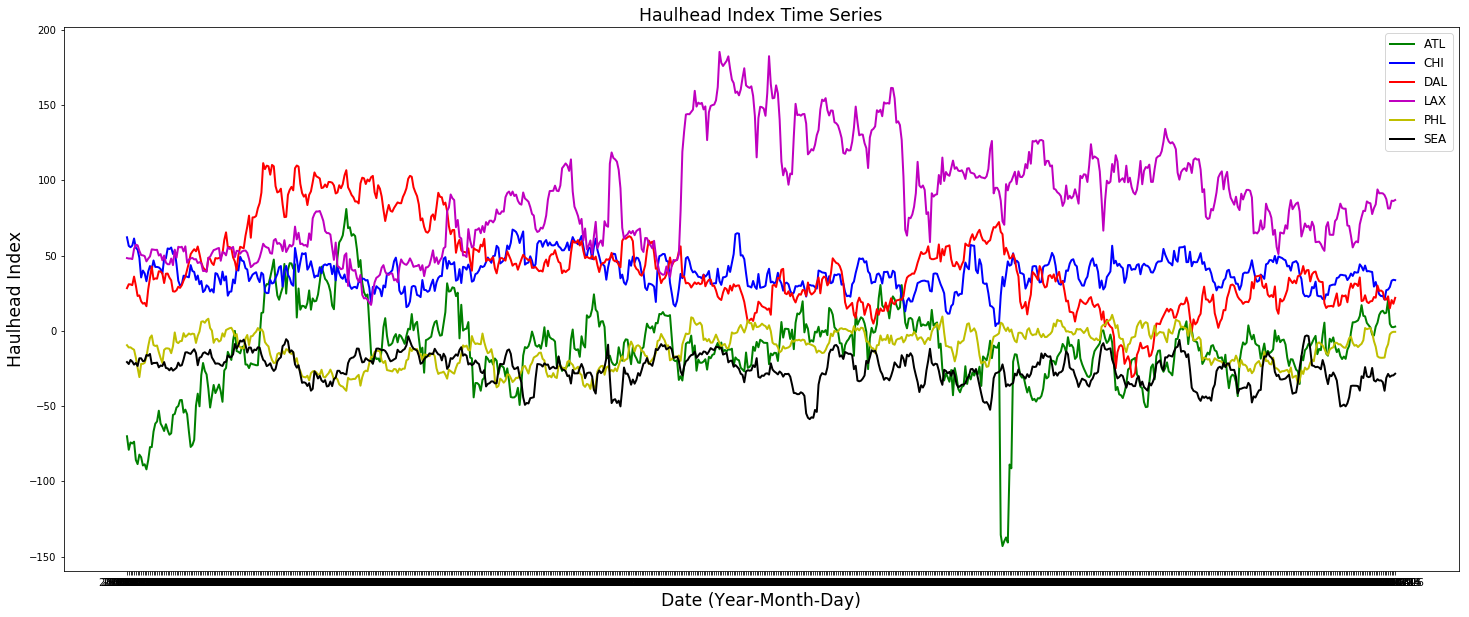

In [102]:
fig10 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Haulhead Index Time Series',fontsize='xx-large')
plt.ylabel('Haulhead Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### INTRM

In [103]:
INTRM=FreightWaves[FreightWaves['ticker']=='INTRM']

In [104]:
set(INTRM['granularity1'])

{'ATLLIN', 'CHIATL', 'DALLAX', 'LAXDAL', 'LAXSEA', 'LINCHI', 'SEALAX'}

In [105]:
#per = INTRM.data_timestamp.dt.to_period("D")

In [106]:
INTRM_value=INTRM.groupby(['granularity1','data_timestamp']).mean()

In [107]:
INTRM_value=INTRM_value.reset_index()

In [108]:
intrm_van=list(INTRM_value[INTRM_value['granularity1']=='ATLLIN']['data_timestamp'])
intrm_vca=list(INTRM_value[INTRM_value['granularity1']=='CHIATL']['data_timestamp'])
intrm_vdl=list(INTRM_value[INTRM_value['granularity1']=='DALLAX']['data_timestamp'])
intrm_vld=list(INTRM_value[INTRM_value['granularity1']=='LAXDAL']['data_timestamp'])
intrm_vls=list(INTRM_value[INTRM_value['granularity1']=='LAXSEA']['data_timestamp'])
intrm_vnc=list(INTRM_value[INTRM_value['granularity1']=='LINCHI']['data_timestamp'])
intrm_vsl=list(INTRM_value[INTRM_value['granularity1']=='SEALAX']['data_timestamp'])

In [109]:
x_van=[]
x_vca=[]
x_vdl=[]
x_vld=[]
x_vls=[]
x_vnc=[]
x_vsl=[]

for i in range(len(intrm_van)):
    x_van.append(intrm_van[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vca)):
    x_vca.append(intrm_vca[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vdl)):
    x_vdl.append(intrm_vdl[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vld)):
    x_vld.append(intrm_vld[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vls)):
    x_vls.append(intrm_vls[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vnc)):
    x_vnc.append(intrm_vnc[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vsl)):
    x_vsl.append(intrm_vsl[i].strftime('%Y-%m-%d'))

In [110]:
y_van=INTRM_value[INTRM_value['granularity1']=='ATLLIN']['data_value']
y_vca=INTRM_value[INTRM_value['granularity1']=='CHIATL']['data_value']
y_vdl=INTRM_value[INTRM_value['granularity1']=='DALLAX']['data_value']
y_vld=INTRM_value[INTRM_value['granularity1']=='LAXDAL']['data_value']
y_vls=INTRM_value[INTRM_value['granularity1']=='LAXSEA']['data_value']
y_vnc=INTRM_value[INTRM_value['granularity1']=='LINCHI']['data_value']
y_vsl=INTRM_value[INTRM_value['granularity1']=='SEALAX']['data_value']

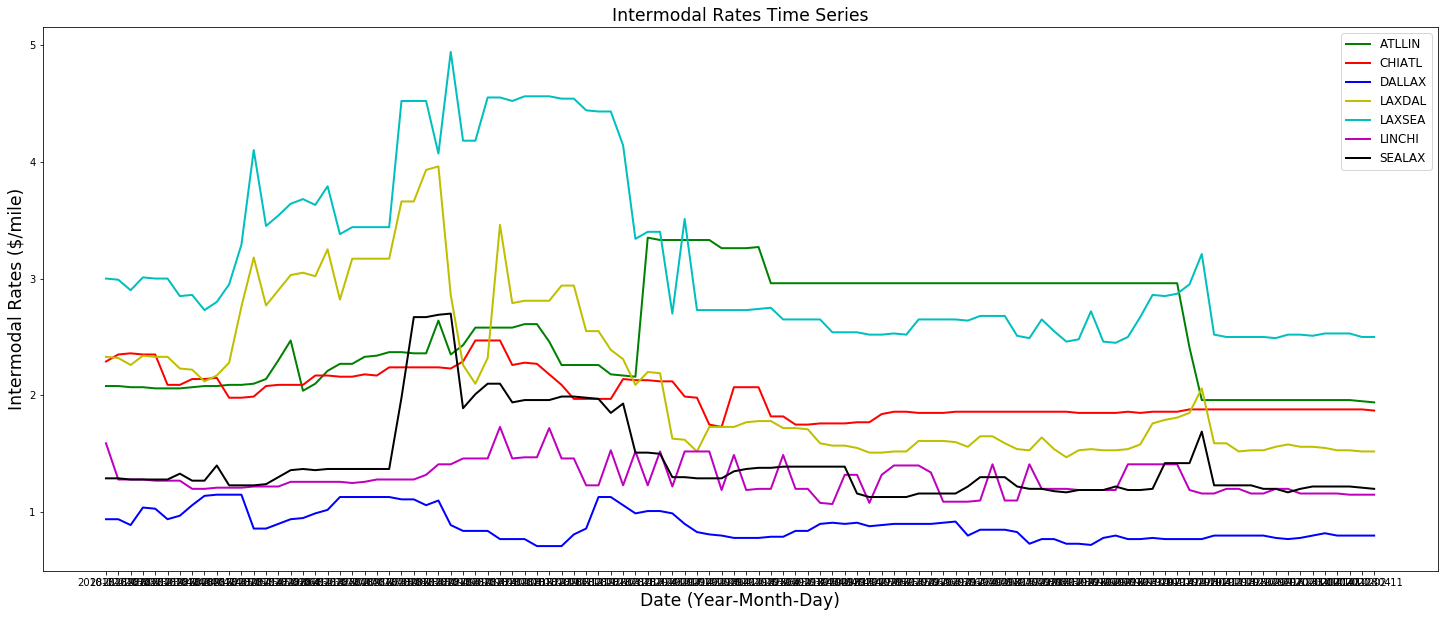

In [111]:
fig11 = plt.figure(figsize=(25,10))
plt.plot(x_van, y_van, marker='', color='g', linewidth=2,label="ATLLIN")
plt.plot(x_vca, y_vca, marker='', color='r', linewidth=2,label="CHIATL")
plt.plot(x_vdl, y_vdl, marker='', color='b', linewidth=2,label="DALLAX")
plt.plot(x_vld, y_vld, marker='', color='y', linewidth=2,label="LAXDAL")
plt.plot(x_vls, y_vls, marker='', color='c', linewidth=2,label="LAXSEA")
plt.plot(x_vnc, y_vnc, marker='', color='m', linewidth=2,label="LINCHI")
plt.plot(x_vsl, y_vsl, marker='', color='k', linewidth=2,label="SEALAX")
plt.title('Intermodal Rates Time Series',fontsize='xx-large')
plt.ylabel('Intermodal Rates ($/mile)',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### IPRO

In [112]:
IPRO=FreightWaves[FreightWaves['ticker']=='IPRO']

In [113]:
set(IPRO['granularity1'])

{'FBEVT', 'USA'}

In [114]:
IPRO_FBEVT=IPRO[IPRO['granularity1']=='FBEVT']

In [115]:
IPRO_FBEVT=IPRO_FBEVT.sort_values(by='data_timestamp').reset_index(drop=True)

In [116]:
IPRO_USA=IPRO[IPRO['granularity1']=='USA']

In [117]:
IPRO_USA=IPRO_USA.sort_values(by='data_timestamp').reset_index(drop=True)

In [118]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']

fig12 = plt.figure(figsize=(25,10))
plt.plot(months, IPRO_FBEVT['data_value'], marker='o', color='g', linewidth=2,label="FBEVT")
plt.plot(months, IPRO_USA['data_value'], marker='o', color='r', linewidth=2,label="USA")
plt.title('Industrial Production Time Series',fontsize='xx-large')
plt.ylabel('Industrial Production',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### ISM

In [119]:
ISM=FreightWaves[FreightWaves['ticker']=='ISM']

In [120]:
ISM=ISM.sort_values(by='data_timestamp').reset_index(drop=True)

Text(0.5, 0, 'Date (Year-Month)')

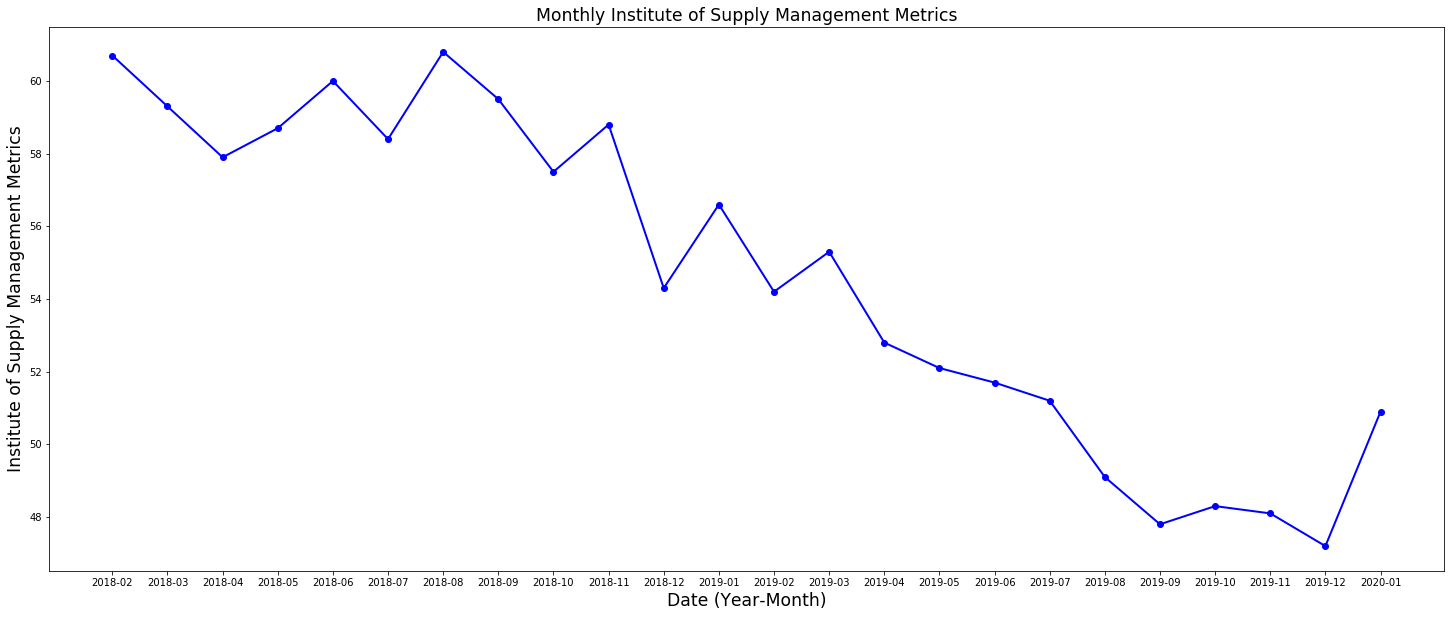

In [121]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']

fig13 = plt.figure(figsize=(25,10))
plt.plot(months, ISM['data_value'], marker='o', color='b', linewidth=2)
plt.title('Monthly Institute of Supply Management Metrics',fontsize='xx-large')
plt.ylabel('Institute of Supply Management Metrics',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

### ORAIL53L

In [122]:
ORAIL53L=FreightWaves[FreightWaves['ticker']=='ORAIL53L']

In [123]:
set(ORAIL53L['granularity1'])

{'ATLPHL', 'CHIATL', 'DALLAX', 'LAXDAL', 'LAXSEA', 'PHLCHI', 'SEALAX'}

In [124]:
#per = ORAIL53L.data_timestamp.dt.to_period("D")

In [125]:
ORAIL53L_value=ORAIL53L.groupby(['granularity1','data_timestamp']).mean()

In [126]:
ORAIL53L_value=ORAIL53L_value.reset_index()

In [127]:
orail53l_vap=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='ATLPHL']['data_timestamp'])
orail53l_vca=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='CHIATL']['data_timestamp'])
orail53l_vdl=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='DALLAX']['data_timestamp'])
orail53l_vld=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='LAXDAL']['data_timestamp'])
orail53l_vls=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='LAXSEA']['data_timestamp'])
orail53l_vpc=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='PHLCHI']['data_timestamp'])
orail53l_vsl=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='SEALAX']['data_timestamp'])

In [128]:
x_vap=[]
x_vca=[]
x_vdl=[]
x_vld=[]
x_vls=[]
x_vpc=[]
x_vsl=[]

for i in range(len(orail53l_vap)):
    x_vap.append(orail53l_vap[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vca)):
    x_vca.append(orail53l_vca[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vdl)):
    x_vdl.append(orail53l_vdl[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vld)):
    x_vld.append(orail53l_vld[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vls)):
    x_vls.append(orail53l_vls[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vpc)):
    x_vpc.append(orail53l_vpc[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vsl)):
    x_vsl.append(orail53l_vsl[i].strftime('%Y-%m-%d'))

In [129]:
y_vap=ORAIL53L_value[ORAIL53L_value['granularity1']=='ATLPHL']['data_value']
y_vca=ORAIL53L_value[ORAIL53L_value['granularity1']=='CHIATL']['data_value']
y_vdl=ORAIL53L_value[ORAIL53L_value['granularity1']=='DALLAX']['data_value']
y_vld=ORAIL53L_value[ORAIL53L_value['granularity1']=='LAXDAL']['data_value']
y_vls=ORAIL53L_value[ORAIL53L_value['granularity1']=='LAXSEA']['data_value']
y_vpc=ORAIL53L_value[ORAIL53L_value['granularity1']=='PHLCHI']['data_value']
y_vsl=ORAIL53L_value[ORAIL53L_value['granularity1']=='SEALAX']['data_value']

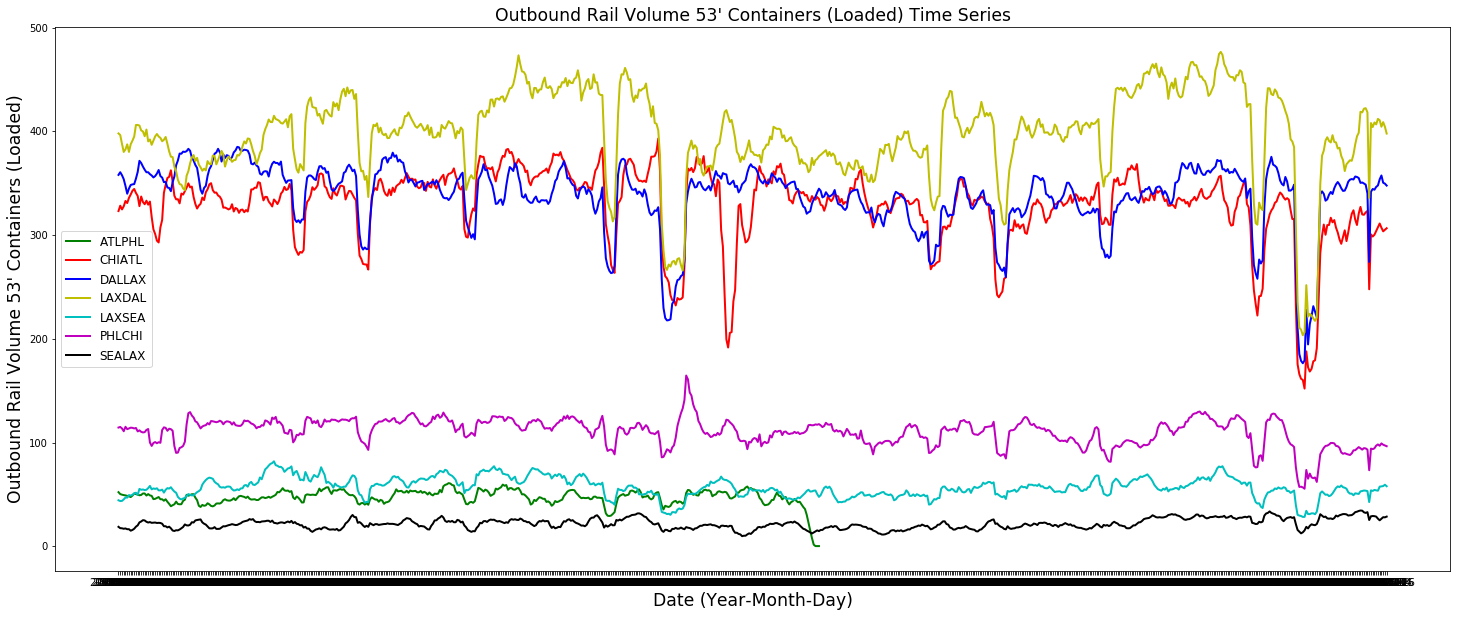

In [130]:
fig14 = plt.figure(figsize=(25,10))
plt.plot(x_vap, y_vap, marker='', color='g', linewidth=2,label="ATLPHL")
plt.plot(x_vca, y_vca, marker='', color='r', linewidth=2,label="CHIATL")
plt.plot(x_vdl, y_vdl, marker='', color='b', linewidth=2,label="DALLAX")
plt.plot(x_vld, y_vld, marker='', color='y', linewidth=2,label="LAXDAL")
plt.plot(x_vls, y_vls, marker='', color='c', linewidth=2,label="LAXSEA")
plt.plot(x_vpc, y_vpc, marker='', color='m', linewidth=2,label="PHLCHI")
plt.plot(x_vsl, y_vsl, marker='', color='k', linewidth=2,label="SEALAX")
plt.title("Outbound Rail Volume 53' Containers (Loaded) Time Series",fontsize='xx-large')
plt.ylabel("Outbound Rail Volume 53' Containers (Loaded)",fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### ORDERS

In [131]:
ORDERS=FreightWaves[FreightWaves['ticker']=='ORDERS']

In [132]:
ORDERS=ORDERS.sort_values(by='data_timestamp').reset_index(drop=True)

In [133]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig15 = plt.figure(figsize=(25,10))
plt.plot(months, ORDERS['data_value'], marker='o', color='k', linewidth=2)
plt.title('Monthly CL8 Trucks Orders',fontsize='xx-large')
plt.ylabel('CL8 Trucks Orders',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month)')

### OTRI

In [134]:
OTRI=FreightWaves[FreightWaves['ticker']=='OTRI']

In [135]:
set(OTRI['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [136]:
#per = OTRI.data_timestamp.dt.to_period("D")

In [137]:
OTRI_value=OTRI.groupby(['granularity1','data_timestamp']).mean()

In [138]:
OTRI_value=OTRI_value.reset_index()

In [139]:
otri_atl=list(OTRI_value[OTRI_value['granularity1']=='ATL']['data_timestamp'])
otri_chi=list(OTRI_value[OTRI_value['granularity1']=='CHI']['data_timestamp'])
otri_dal=list(OTRI_value[OTRI_value['granularity1']=='DAL']['data_timestamp'])
otri_lax=list(OTRI_value[OTRI_value['granularity1']=='LAX']['data_timestamp'])
otri_phl=list(OTRI_value[OTRI_value['granularity1']=='PHL']['data_timestamp'])
otri_sea=list(OTRI_value[OTRI_value['granularity1']=='SEA']['data_timestamp'])

In [140]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(otri_atl)):
    x_atl.append(otri_atl[i].strftime('%Y-%m-%d'))

for i in range(len(otri_chi)):
    x_chi.append(otri_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(otri_dal)):
    x_dal.append(otri_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(otri_lax)):
    x_lax.append(otri_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(otri_phl)):
    x_phl.append(otri_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(otri_sea)):
    x_sea.append(otri_sea[i].strftime('%Y-%m-%d'))

In [141]:
y_atl=OTRI_value[OTRI_value['granularity1']=='ATL']['data_value']
y_chi=OTRI_value[OTRI_value['granularity1']=='CHI']['data_value']
y_dal=OTRI_value[OTRI_value['granularity1']=='DAL']['data_value']
y_lax=OTRI_value[OTRI_value['granularity1']=='LAX']['data_value']
y_phl=OTRI_value[OTRI_value['granularity1']=='PHL']['data_value']
y_sea=OTRI_value[OTRI_value['granularity1']=='SEA']['data_value']

In [142]:
fig16 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Outbound Tender Reject Index Time Series',fontsize='xx-large')
plt.ylabel('Outbound Tender Reject Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### OTVI

In [143]:
OTVI=FreightWaves[FreightWaves['ticker']=='OTVI']

In [144]:
set(OTVI['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [145]:
#per = OTVI.data_timestamp.dt.to_period("D")

In [146]:
OTVI_value=OTVI.groupby(['granularity1','data_timestamp']).mean()

In [147]:
OTVI_value=OTVI_value.reset_index()

In [148]:
otvi_atl=list(OTVI_value[OTVI_value['granularity1']=='ATL']['data_timestamp'])
otvi_chi=list(OTVI_value[OTVI_value['granularity1']=='CHI']['data_timestamp'])
otvi_dal=list(OTVI_value[OTVI_value['granularity1']=='DAL']['data_timestamp'])
otvi_lax=list(OTVI_value[OTVI_value['granularity1']=='LAX']['data_timestamp'])
otvi_phl=list(OTVI_value[OTVI_value['granularity1']=='PHL']['data_timestamp'])
otvi_sea=list(OTVI_value[OTVI_value['granularity1']=='SEA']['data_timestamp'])

In [149]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(otvi_atl)):
    x_atl.append(otvi_atl[i].strftime('%Y-%m-%d'))

for i in range(len(otvi_chi)):
    x_chi.append(otvi_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(otvi_dal)):
    x_dal.append(otvi_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(otvi_lax)):
    x_lax.append(otvi_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(otvi_phl)):
    x_phl.append(otvi_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(otvi_sea)):
    x_sea.append(otvi_sea[i].strftime('%Y-%m-%d'))

In [150]:
y_atl=OTVI_value[OTVI_value['granularity1']=='ATL']['data_value']
y_chi=OTVI_value[OTVI_value['granularity1']=='CHI']['data_value']
y_dal=OTVI_value[OTVI_value['granularity1']=='DAL']['data_value']
y_lax=OTVI_value[OTVI_value['granularity1']=='LAX']['data_value']
y_phl=OTVI_value[OTVI_value['granularity1']=='PHL']['data_value']
y_sea=OTVI_value[OTVI_value['granularity1']=='SEA']['data_value']

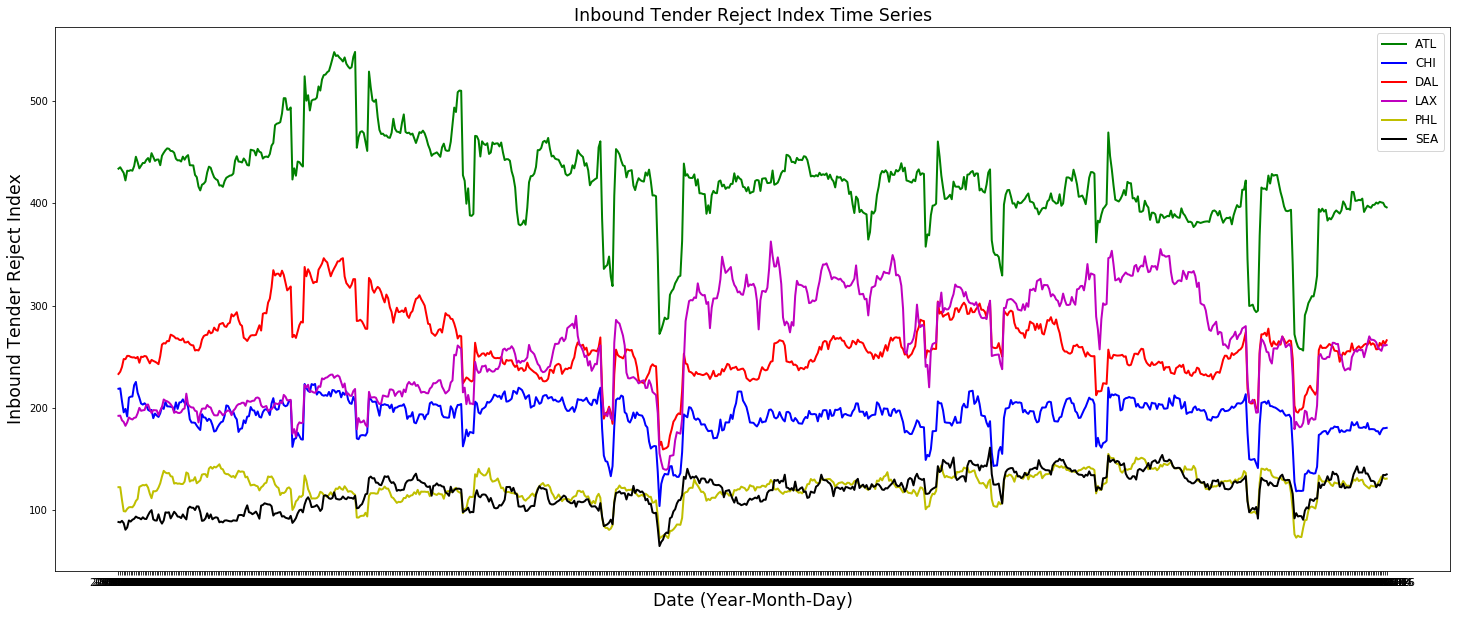

In [151]:
fig17 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Inbound Tender Reject Index Time Series',fontsize='xx-large')
plt.ylabel('Inbound Tender Reject Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### PPI

In [152]:
PPI=FreightWaves[FreightWaves['ticker']=='PPI']

In [153]:
PPI=PPI.sort_values(by='data_timestamp').reset_index(drop=True)

Text(0.5, 0, 'Date (Year-Month)')

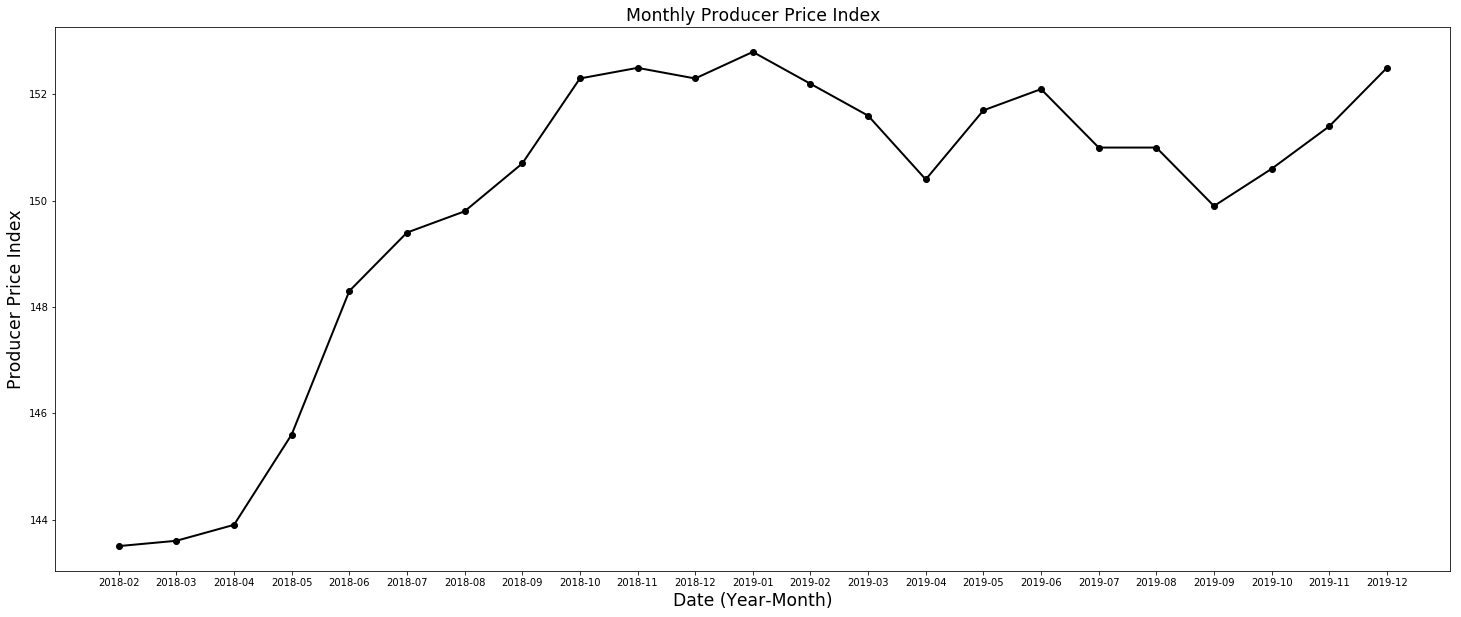

In [154]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig18 = plt.figure(figsize=(25,10))
plt.plot(months, PPI['data_value'], marker='o', color='k', linewidth=2)
plt.title('Monthly Producer Price Index',fontsize='xx-large')
plt.ylabel('Producer Price Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

### RESLG

In [155]:
RESLG=FreightWaves[FreightWaves['ticker']=='RESLG']

In [156]:
RESLG=RESLG.sort_values(by='data_timestamp').reset_index(drop=True)

Text(0.5, 0, 'Date (Year-Month)')

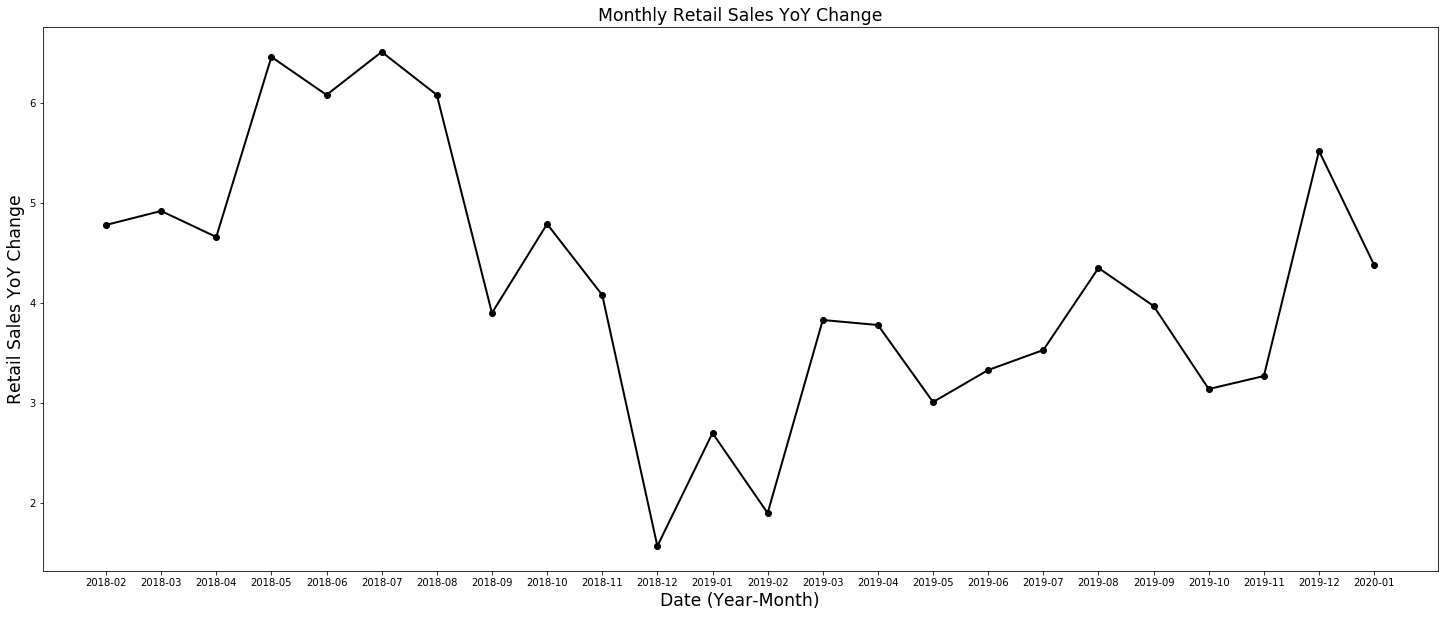

In [157]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']

fig19 = plt.figure(figsize=(25,10))
plt.plot(months, RESLG['data_value'], marker='o', color='k', linewidth=2)
plt.title('Monthly Retail Sales YoY Change',fontsize='xx-large')
plt.ylabel('Retail Sales YoY Change',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

### TLT

In [158]:
TLT=FreightWaves[FreightWaves['ticker']=='TLT']

In [159]:
set(TLT['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [160]:
#per = TLT.data_timestamp.dt.to_period("D")

In [161]:
TLT_value=TLT.groupby(['granularity1','data_timestamp']).mean()

In [162]:
TLT_value=TLT_value.reset_index()

In [163]:
tlt_atl=list(TLT_value[TLT_value['granularity1']=='ATL']['data_timestamp'])
tlt_chi=list(TLT_value[TLT_value['granularity1']=='CHI']['data_timestamp'])
tlt_dal=list(TLT_value[TLT_value['granularity1']=='DAL']['data_timestamp'])
tlt_lax=list(TLT_value[TLT_value['granularity1']=='LAX']['data_timestamp'])
tlt_phl=list(TLT_value[TLT_value['granularity1']=='PHL']['data_timestamp'])
tlt_sea=list(TLT_value[TLT_value['granularity1']=='SEA']['data_timestamp'])

In [164]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(tlt_atl)):
    x_atl.append(tlt_atl[i].strftime('%Y-%m-%d'))

for i in range(len(tlt_chi)):
    x_chi.append(tlt_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(tlt_dal)):
    x_dal.append(tlt_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(tlt_lax)):
    x_lax.append(tlt_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(tlt_phl)):
    x_phl.append(tlt_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(tlt_sea)):
    x_sea.append(tlt_sea[i].strftime('%Y-%m-%d'))

In [165]:
y_atl=TLT_value[TLT_value['granularity1']=='ATL']['data_value']
y_chi=TLT_value[TLT_value['granularity1']=='CHI']['data_value']
y_dal=TLT_value[TLT_value['granularity1']=='DAL']['data_value']
y_lax=TLT_value[TLT_value['granularity1']=='LAX']['data_value']
y_phl=TLT_value[TLT_value['granularity1']=='PHL']['data_value']
y_sea=TLT_value[TLT_value['granularity1']=='SEA']['data_value']

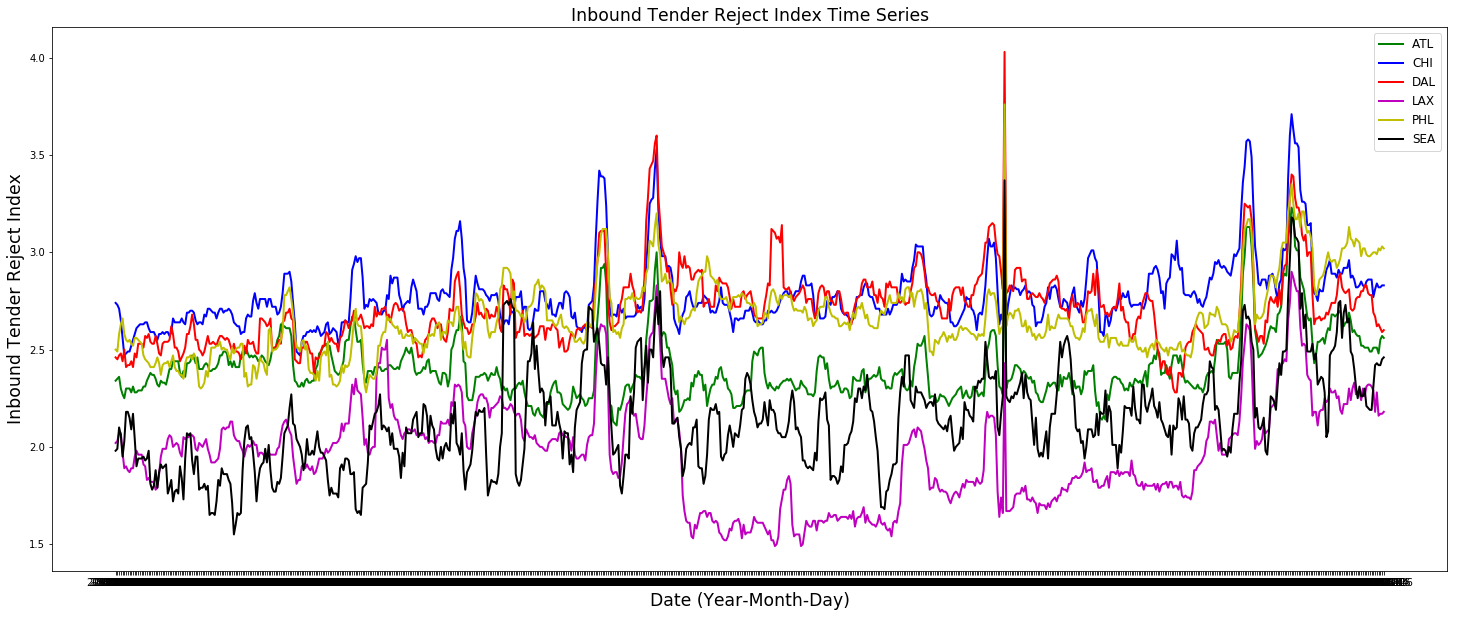

In [166]:
fig20 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Inbound Tender Reject Index Time Series',fontsize='xx-large')
plt.ylabel('Inbound Tender Reject Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### Rates

### Preprocessing

In [167]:
Q5=Q5.drop(columns=['Pickup Date','Delivery Date','Origin State','Dest State','Revenue'])

In [168]:
Q5=Q5.replace('Atlanta', 'ATL')
Q5=Q5.replace('Chicago', 'CHI')
Q5=Q5.replace('Dallas', 'DAL')
Q5=Q5.replace('Philadelphia', 'PHL')
Q5=Q5.replace('Seattle', 'SEA')
Q5=Q5.replace('Los Angeles', 'LAX')

In [169]:
Q5.head()

Load Number  Book Date Origin Market  3-Digit Origin # Dest Market  \
0         1280 2018-02-15           LAX               906         NaN   
1         1282 2018-02-15           CHI               601         CHI   
2         1340 2018-02-16           CHI               606         CHI   
3         1397 2018-02-19           DAL               761         DAL   
4         1398 2018-02-21           DAL               761         DAL   

  3-Digit Dest #     Mode  Mileage Spot/Contract  Accessorial Cost  \
0            554  Dry Van   3816.0          Spot                 0   
1            606  Dry Van     48.0          Spot               -42   
2            607  Dry Van     42.0          Spot                 0   
3            761  Dry Van     60.0          Spot                 0   
4            761  Dry Van     60.0          Spot                 0   

    Load Type   Lane       RPM  
0      Ad-hoc  Other  0.934958  
1      Ad-hoc  Other  4.236458  
2   Dedicated  Other  8.187619  
3  Consistent  Other  5.191167  
4      Ad-hoc  Other  5.191167

In [170]:
sum(Q5['RPM']>20)/len(Q5)

0.012654655958324289

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(0, 20)

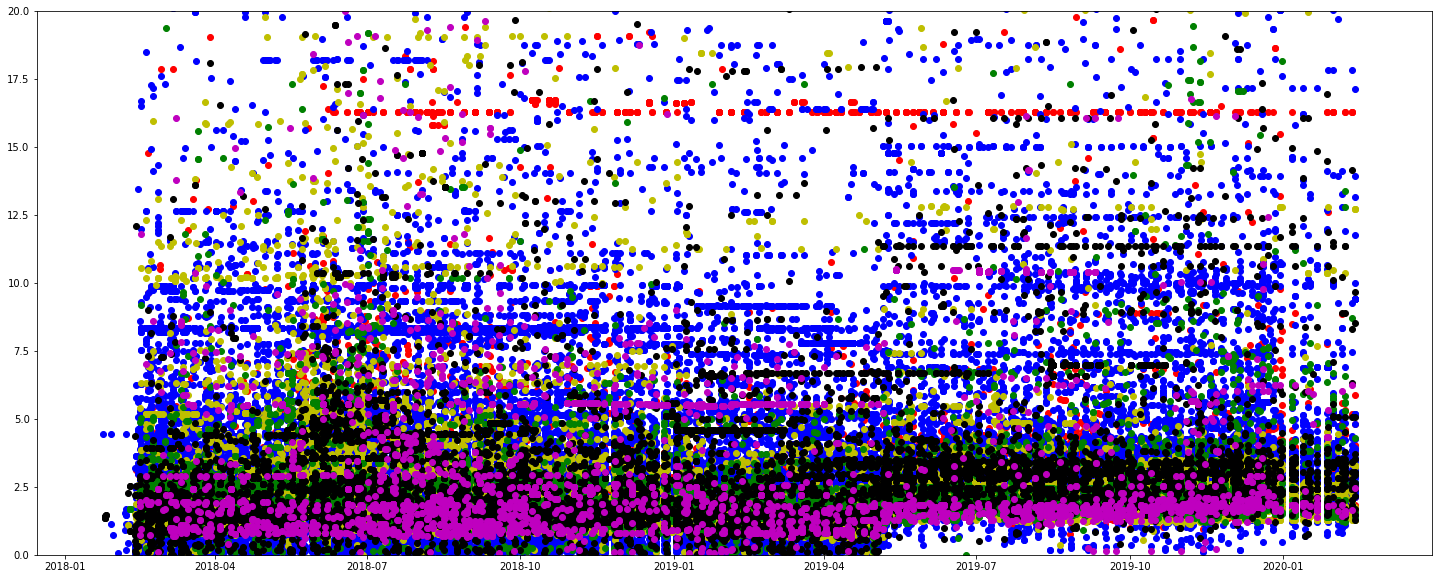

In [171]:
fig21 = plt.figure(figsize=(25,10))
plt.scatter(Q5[Q5['Origin Market']=='ATL']['Book Date'], Q5[Q5['Origin Market']=='ATL']['RPM'],color='r')
plt.scatter(Q5[Q5['Origin Market']=='CHI']['Book Date'], Q5[Q5['Origin Market']=='CHI']['RPM'],color='b')
plt.scatter(Q5[Q5['Origin Market']=='DAL']['Book Date'], Q5[Q5['Origin Market']=='DAL']['RPM'],color='y')
plt.scatter(Q5[Q5['Origin Market']=='PHL']['Book Date'], Q5[Q5['Origin Market']=='PHL']['RPM'],color='g')
plt.scatter(Q5[Q5['Origin Market']=='LAX']['Book Date'], Q5[Q5['Origin Market']=='LAX']['RPM'],color='k')
plt.scatter(Q5[Q5['Origin Market']=='SEA']['Book Date'], Q5[Q5['Origin Market']=='SEA']['RPM'],color='m')
plt.ylim(0, 20)

In [172]:
FreightWaves.head()

ticker granularity1    symbol data_timestamp  data_value  \
0   COSP          RES  COSP.RES     2019-04-30    512113.0   
1   COSP          RES  COSP.RES     2019-09-30    529455.0   
2   COSP          RES  COSP.RES     2019-11-30    540457.0   
3   COSP          RES  COSP.RES     2018-02-28    577315.0   
4   COSP          RES  COSP.RES     2018-12-31    517951.0   

                               index_name  Description  
0  Total Construction Spending (000,000s)  Residential  
1  Total Construction Spending (000,000s)  Residential  
2  Total Construction Spending (000,000s)  Residential  
3  Total Construction Spending (000,000s)  Residential  
4  Total Construction Spending (000,000s)  Residential

### Feature Engineering

In [173]:
set(FreightWaves['ticker'])

{'COSP',
 'CSTM',
 'DATVF',
 'DTS',
 'HAUL',
 'INTRM',
 'IPRO',
 'ISM',
 'ORAIL53L',
 'ORDERS',
 'OTRI',
 'OTVI',
 'PPI',
 'RESLG',
 'TLT'}

### macro_fn (Macro function moved to be a part of the larger function for sake of efficiency.)

    Function which takes in a timestamp for a Shipper Book date and a Macro Indicator df and returns the data value for the Macro Indicator that the shipper would've referenced to make their rate decision (i.e. the most recent reporting of the macro indicator)
    
   #### Relevant macro indicators: ISM, IRPO_USA, IPRO_FBEVT, PPI, COSP, RESLG, and ORDERS

### the_new_min_function

    Takes in a city, a day (timestamp), and a number of days to look back (int). It returns a list of index values that are at earliest the number of days back from the given day. 
    
    Example:
    
    f('LAX', Timestamp('2018-02-25 00:00:00')) -> (12.1, 1500, 13.5, 0, 0, 5.4)
    
   #### Relevant indecies include: OTVI, OTRI, HAUL, TLT, DTS, and CSTM

In [174]:
otvi_to_val = {}
for i in zip(list(OTVI_value.granularity1),list(OTVI_value.data_timestamp), list(OTVI_value.data_value)):
    otvi_to_val[(i[0], i[1])] = i[2]

otri_to_val = {}
for i in zip(list(OTRI_value.granularity1),list(OTRI_value.data_timestamp), list(OTRI_value.data_value)):
    otri_to_val[(i[0], i[1])] = i[2] 

haul_to_val = {}
for i in zip(list(HAUL_value.granularity1),list(HAUL_value.data_timestamp), list(HAUL_value.data_value)):
    haul_to_val[(i[0], i[1])] = i[2] 

tlt_to_val = {}
for i in zip(list(TLT_value.granularity1),list(TLT_value.data_timestamp), list(TLT_value.data_value)):
    tlt_to_val[(i[0], i[1])] = i[2] 

dts_to_val = {}
for i in zip(list(DTS_value.granularity1),list(DTS_value.data_timestamp), list(DTS_value.data_value)):
    dts_to_val[(i[0], i[1])] = i[2] 

cstm_to_val = {}
for i in zip(list(CSTM_value.granularity1),list(CSTM_value.data_timestamp), list(CSTM_value.data_value)):
    cstm_to_val[(i[0], i[1])] = i[2]

In [175]:
def the_new_min_function(city: str, time: pd.Timestamp, days_back) -> list:
    cur = time
    days_back += 1
    otvi = np.nan
    otri = np.nan
    haul = np.nan
    tlt = np.nan
    dts = np.nan
    cstm = np.nan

    for i in range(days_back):
        if (city, cur) in otvi_to_val:
            otvi = otvi_to_val[(city, cur)]
            break
        cur = time - pd.Timedelta(days=i)
    cur = time

    for i in range(days_back):
        if (city, cur) in otri_to_val:
            otri = otri_to_val[(city, cur)]
            break
        cur = time - pd.Timedelta(days=i)
    cur = time

    for i in range(days_back):
        if (city, cur) in haul_to_val:
            haul = haul_to_val[(city, cur)]
            break
        cur = time - pd.Timedelta(days=i)
    cur = time

    for i in range(days_back):
        if (city, cur) in tlt_to_val:
            tlt = tlt_to_val[(city, cur)]
            break
        cur = time - pd.Timedelta(days=i)
    cur = time

    for i in range(days_back):
        if (city, cur) in dts_to_val:
            dts = dts_to_val[(city, cur)]
            break
        cur = time - pd.Timedelta(days=i)
    cur = time

    for i in range(days_back):
        if (city, cur) in cstm_to_val:
            cstm = cstm_to_val[(city, cur)]
            break
        cur = time - pd.Timedelta(days=i)
    cur = time

    return [otvi, otri, haul, tlt, dts, cstm]

### the_new_lane_function

    Takes in a lane, a day (timestamp), and a number of days to look back (int). It returns a list of index values that are at earliest the number of days back from the given day. 
    
    Example:
    
    f('VLS', Timestamp('2018-02-25 00:00:00')) -> (12.1, 1500, 13.5, 0, 0, 5.4)
    
   #### Relevant indecies include: DATVF, ORAIL53L, and INTRM,

In [176]:
ltc = {}
ltc['Other'] = np.nan
ltc['VLS'] = 'LAXSEA'
ltc['VSL'] = 'SEALAX'
ltc['VLD'] = 'LAXDAL'
ltc['VDL'] = 'DALLAX'
ltc['VCA'] = 'CHIATL'
ltc['VAP'] = 'ATLPHL'
ltc['VPC'] = 'PHLCHI'

In [177]:
datvf_to_val = {}
for i in zip(list(DATVF_value.granularity1),list(DATVF_value.data_timestamp), list(DATVF_value.data_value)):
    datvf_to_val[(i[0], i[1])] = i[2]
    
orail53l_to_val = {}
for i in zip(list(ORAIL53L_value.granularity1),list(ORAIL53L_value.data_timestamp), list(ORAIL53L_value.data_value)):
    orail53l_to_val[(i[0], i[1])] = i[2]
    
intrm_to_val = {}
for i in zip(list(INTRM_value.granularity1),list(INTRM_value.data_timestamp), list(INTRM_value.data_value)):
    intrm_to_val[(i[0], i[1])] = i[2]

In [178]:
def the_new_lane_function(lane:str, time: pd.Timestamp, days_back:int) -> list:
    lane = ltc[lane]
    if lane == np.nan:
        return [np.nan, np.nan, np.nan]

    cur = time
    days_back += 1
    datv = np.nan
    orai = np.nan
    intr = np.nan

    for i in range(days_back):
        if (lane, cur) in datvf_to_val:
            datv = datvf_to_val[(lane, cur)]
            break
        cur = time - pd.Timedelta(days=i)
    cur = time 

    for i in range(days_back):
        if (lane, cur) in orail53l_to_val:
            orai = orail53l_to_val[(lane, cur)]
            break
        cur = time - pd.Timedelta(days=i)
    cur = time 

    for i in range(days_back):
        if (lane, cur) in intrm_to_val:
            intr = intrm_to_val[(lane, cur)]
            break
        cur = time - pd.Timedelta(days=i)
    cur = time 

    return [datv, orai, intr]

### Preprocessing notes:
    - Take out all rows with book dates before 2018-02-28, or the last indicator date, so that there should be no NaN values in the df
    - Remove all rows where the book date is after the delivery date

In [179]:
def pred_df(df):
    pred_df=[]
    rates=list(df['RPM'])
    contract=list(df['Spot/Contract'])
    load_type = list(df['Load Type'])
    mileage = list(df['Mileage'])
    dist = []

    cities = list(df['Origin Market'])
    times = list(df['Book Date'])
    
    lanes = list(df['Lane'])

    ism_values = ISM['data_value']
    ipro_usa_values=IPRO_USA['data_value']
    ipro_fbevt_values=IPRO_FBEVT['data_value']
    ppi_values=PPI['data_value']
    cosp_values=COSP['data_value']
    reslg_values=RESLG['data_value']
    orders_values=ORDERS['data_value']

    for i in range(len(df)):    
        
        #dist.append(to_dist_ind(mileage[i]))
        if mileage[i]=='(blank)' or mileage[i]<100:
            dist.append('C')
        elif mileage[i] <= 250:
            dist.append('S')
        elif mileage[i] <= 450:
            dist.append('M')
        elif mileage[i] <= 800:
            dist.append('T')
        else:
            dist.append('L')
        
        # Macro:
        date = df.loc[i]['Book Date']

        dates1=list(PPI['data_timestamp'])
        dates1.insert(0,date)
        dates1.sort()
        index1 = dates1.index(date)

        dates2=list(ISM['data_timestamp'])
        dates2.insert(0,date)
        dates2.sort()
        index2 = dates2.index(date)

        if index1 > 0 and index2 > 0:
            ism=ism_values[index2-1]
            ipro_usa=ipro_usa_values[index2-1]
            ipro_fbevt=ipro_fbevt_values[index2-1]
            ppi=ppi_values[index1-1]
            cosp=cosp_values[index1-1]
            reslg=reslg_values[index2-1]
            orders=orders_values[index1-1]
        else:
            ism=np.nan
            ipro_usa=np.nan
            ipro_fbevt=np.nan
            ppi=np.nan
            cosp=np.nan
            reslg=np.nan
            orders=np.nan

        # Micro Location Data     
        #loc = df.loc[i]['Origin Market']

        city = cities[i]
        time = times[i] - pd.Timedelta(days=1)
        days_back=5

        micro_loc = the_new_min_function(city, time, days_back)
        otvi=micro_loc[0]
        otri=micro_loc[1]
        haul=micro_loc[2]
        tlt=micro_loc[3]
        dts=micro_loc[4]
        cstm=micro_loc[5]

        lane = lanes[i]

        micro_lane = the_new_lane_function(lane, time, days_back)
        datvf=micro_lane[0]
        orail53l=micro_lane[1]
        intrm=micro_lane[2]

        pred_df.append([date,dist[i],contract[i],load_type[i],ism,ipro_usa,ipro_fbevt,ppi,cosp,reslg,orders,otvi,otri,haul,tlt,dts,cstm,datvf,orail53l,intrm,rates[i]])
    
    return pred_df;

In [180]:
pred_df=pd.DataFrame(pred_df(Q5),columns=['date','dist','contract','load_type','ism','ipro_usa','ipro_fbevt','ppi','cosp','reslg','orders','otvi','otri','haul','tlt','dts','cstm','datvf','orail53l','intrm','RPM'])


In [181]:
pred_df.head()

date dist contract   load_type  ism  ipro_usa  ipro_fbevt  ppi  cosp  \
0 2018-02-15    L     Spot      Ad-hoc  NaN       NaN         NaN  NaN   NaN   
1 2018-02-15    C     Spot      Ad-hoc  NaN       NaN         NaN  NaN   NaN   
2 2018-02-16    C     Spot   Dedicated  NaN       NaN         NaN  NaN   NaN   
3 2018-02-19    C     Spot  Consistent  NaN       NaN         NaN  NaN   NaN   
4 2018-02-21    C     Spot      Ad-hoc  NaN       NaN         NaN  NaN   NaN   

   reslg  ...   otvi   otri  haul   tlt  dts  cstm  datvf  orail53l  intrm  \
0    NaN  ...    NaN    NaN   NaN   NaN  NaN   NaN    NaN       NaN    NaN   
1    NaN  ...    NaN    NaN   NaN   NaN  NaN   NaN    NaN       NaN    NaN   
2    NaN  ...    NaN    NaN   NaN   NaN  NaN   NaN    NaN       NaN    NaN   
3    NaN  ...  235.2  14.70   NaN  2.45  NaN   NaN    NaN       NaN    NaN   
4    NaN  ...  247.6  14.02   NaN  2.48  NaN   NaN    NaN       NaN    NaN   

        RPM  
0  0.934958  
1  4.236458  
2  8.187619  
3  5.191167  
4  5.191167  

[5 rows x 21 columns]

## Taking out dates before 3-13-2018

In [182]:
from datetime import *
new_df=pred_df[pred_df['date'] > date(2018,3,12)]

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


## Breaking into dfs based on distance:

### City Distance

In [183]:
city_df=new_df[new_df['dist']=='C']

In [184]:
city_df=city_df.drop(columns=['datvf','orail53l','intrm','date','dist']).dropna()

In [185]:
Q5.loc[173]

Load Number                       13375
Book Date           2018-03-22 00:00:00
Origin Market                       CHI
3-Digit Origin #                    601
Dest Market                         NaN
3-Digit Dest #                      477
Mode                            Dry Van
Mileage                             618
Spot/Contract                      Spot
Accessorial Cost                      0
Load Type                        Ad-hoc
Lane                              Other
RPM                            0.889968
Name: 173, dtype: object

In [186]:
city_df=pd.get_dummies(city_df, prefix=['contract', 'load_type'])

In [187]:
city_df.head()

ism  ipro_usa  ipro_fbevt    ppi      cosp  reslg   orders   otvi  \
126  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  194.5   
128  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  194.5   
130  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  194.5   
131  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  194.5   
137  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  194.5   

      otri  haul  ...  cstm        RPM  contract_Contract  contract_Spot  \
126  28.29  39.3  ...  2.43   8.336944                  0              1   
128  28.29  39.3  ...  2.43   8.336944                  0              1   
130  28.29  39.3  ...  2.43   8.336944                  0              1   
131  28.29  39.3  ...  2.43   8.336944                  0              1   
137  28.29  39.3  ...  2.43  12.635000                  0              1   

     load_type_Ad-hoc  load_type_Consistent  load_type_Critical  \
126                 0                     0                   0   
128                 0                     0                   0   
130                 0                     0                   0   
131                 0                     0                   0   
137                 0                     0                   0   

     load_type_Dedicated  load_type_Standard  load_type_White Glove  
126                    1                   0                      0  
128                    1                   0                      0  
130                    1                   0                      0  
131                    1                   0                      0  
137                    1                   0                      0  

[5 rows x 22 columns]

### Correlation Matrix

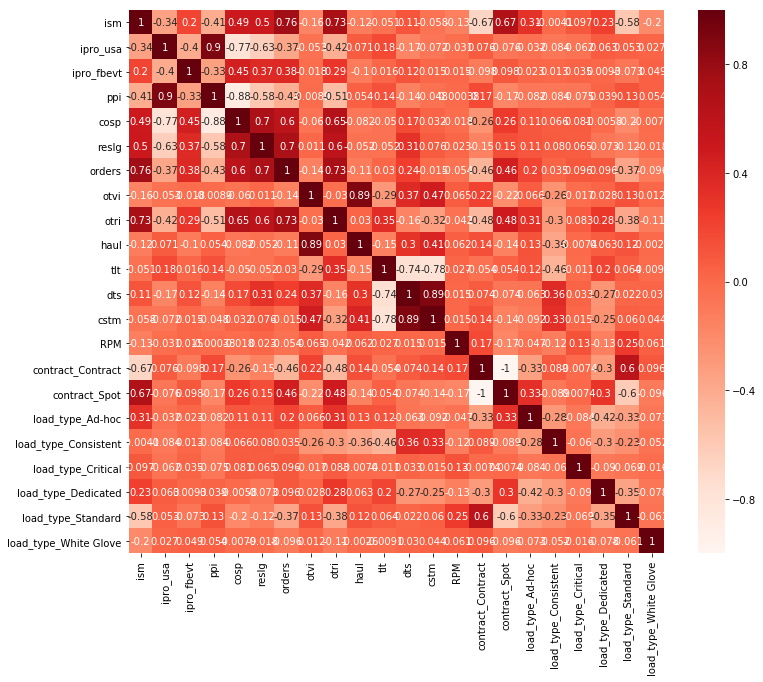

In [188]:
#Using Pearson Correlation
fig21=plt.figure(figsize=(12,10))
cor = city_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [189]:
cor_target = abs(cor['RPM'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

ism                     0.126018
RPM                     1.000000
contract_Contract       0.174930
contract_Spot           0.174930
load_type_Consistent    0.123230
load_type_Critical      0.130365
load_type_Dedicated     0.129803
load_type_Standard      0.251181
Name: RPM, dtype: float64

Nothing is very highly correlated with RPM, the dependent variable. However, certain independent variables are highly correlated with one another.

In [190]:
y_ext = city_df.loc[:, city_df.columns == 'RPM']
X_ext = city_df.iloc[:,0:13]

### Backward Elimination

In [191]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_ext)
#Fitting sm.OLS model
model = sm.OLS(y_ext,X_1).fit()
model.pvalues

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const         4.510071e-09
ism           4.173483e-30
ipro_usa      6.613479e-05
ipro_fbevt    2.357511e-01
ppi           5.414488e-01
cosp          4.541143e-06
reslg         3.444574e-05
orders        4.853971e-01
otvi          1.783942e-02
otri          6.919020e-03
haul          3.254504e-04
tlt           5.650378e-02
dts           1.005264e-02
cstm          2.993027e-01
dtype: float64

In [192]:
#Backward Elimination
cols = list(X_ext.columns)
pmax = 1

while (len(cols)>0):
    p= []
    X_1 = X_ext[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_ext,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['ism', 'ipro_usa', 'cosp', 'reslg', 'otvi', 'otri', 'haul', 'tlt', 'dts']


### Recursive Feature Elimination

In [193]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 3)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_ext,y_ext)  

#Fitting the data to model
model.fit(X_rfe,y_ext)
print(rfe.support_)
print(rfe.ranking_)

[False  True False False False False False False False False  True  True
 False]
[ 2  1  5  4  9  3 11  8  6  7  1  1 10]


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [194]:
X_ext.columns

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm'],
      dtype='object')

#### RFE selects: IPRO_USA, TLT and DTS when given only external factors

In [195]:
y = city_df.loc[:, city_df.columns == 'RPM']
X = city_df.loc[:, city_df.columns != 'RPM']

In [196]:
#no of features
nof_list=np.arange(1,23)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

Optimum number of features: 20
Score with 20 features: 0.073571


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

In [197]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 20)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'otvi', 'otri',
       'haul', 'tlt', 'dts', 'cstm', 'contract_Contract', 'contract_Spot',
       'load_type_Ad-hoc', 'load_type_Consistent', 'load_type_Critical',
       'load_type_Dedicated', 'load_type_Standard', 'load_type_White Glove'],
      dtype='object')


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Quick Linear Regression Model

In [198]:
predictors=['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'otvi', 'otri',
       'haul', 'tlt', 'dts', 'cstm', 'contract_Contract', 'contract_Spot',
       'load_type_Ad-hoc', 'load_type_Consistent', 'load_type_Critical',
       'load_type_Dedicated', 'load_type_Standard', 'load_type_White Glove']
X_c=X[predictors]
y_c=y['RPM']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.2, random_state=0)

In [200]:
model = LinearRegression()
result=model.fit(X_train,y_train)

In [201]:
print(model.intercept_)

97.84020242923837


In [202]:
print(model.coef_)

[-8.57044850e-02 -4.82562007e-01  3.01747691e-01 -1.39072737e-01
 -7.00918957e-05  3.02861572e-01 -7.84153014e-03  1.40102461e-01
  5.86246982e-03 -1.16777686e+00 -3.20045753e-01  4.64041727e-05
  7.04543100e-01 -7.04543100e-01 -3.79437177e+00 -6.51756107e+00
  9.51537475e+00 -5.28454176e+00  2.97777290e+00  3.10332696e+00]


In [203]:
y_pred = model.predict(X_test)

In [204]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.head()

Actual  Predicted
88968   7.461512  15.162931
60824  15.088415  15.743307
42715   4.552903   5.939541
71049  11.779935  17.406805
51427   4.561935   6.873463

In [205]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.318820945690395
Mean Squared Error: 92.37434110355643
Root Mean Squared Error: 9.611157115746076


In [206]:
model.score(X_test,y_test)

0.15282804803160854

### Polynomial Regression

In [207]:
from sklearn.preprocessing import PolynomialFeatures 
  
poly = PolynomialFeatures(degree = 2) 
X_poly = poly.fit_transform(X)

In [208]:
X_poly.size/len(X_poly)

253.0

In [209]:
########### Don't run this, it takes too long. Just trust that the following variables were outputted ###########
#no of features
#nof_list=np.arange(1,254)            
#high_score=0

#Variable to store the optimum features
#nof=0           
#score_list =[]
#for n in range(len(nof_list)):
    #X_train, X_test, y_train, y_test = train_test_split(X_poly,y, test_size = 0.5, random_state = 0)
    #model = LinearRegression()
    #rfe = RFE(model,nof_list[n])
    #X_train_rfe = rfe.fit_transform(X_train,y_train)
    #X_test_rfe = rfe.transform(X_test)
    #model.fit(X_train_rfe,y_train)
    #score = model.score(X_test_rfe,y_test)
    #score_list.append(score)
    #if(score>high_score):
        #high_score = score
        #nof = nof_list[n]
#print("Optimum number of features: %d" %nof)
#print("Score with %d features: %f" % (nof, high_score))

In [210]:
X_poly=pd.DataFrame(X_poly)

In [211]:
#cols = list(X_poly.columns)
#model = LinearRegression()

#Initializing RFE model
#rfe = RFE(model, 27)             

#Transforming data using RFE
#X_rfe = rfe.fit_transform(X_poly,y)  

#Fitting the data to model
#model.fit(X_rfe,y)              
#temp = pd.Series(rfe.support_,index = cols)
#selected_features_rfe = temp[temp==True].index
#print(selected_features_rfe)

In [212]:
predictors=[  2,  11,  14,  15,  16,  17,  19,  20,  55,  56, 192, 193, 195,
            196, 217, 221, 224, 225, 226, 227, 228, 229, 230, 232, 238, 247,
            250]
X_poly_preds=X_poly[predictors]
y_poly=y['RPM']

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_preds, y_poly, test_size=0.2, random_state=0)

In [214]:
poly.fit(X_train, y_train) 
model2 = LinearRegression() 
results2=model2.fit(X_train, y_train)

In [215]:
print(model2.intercept_)

190.44761662731423


In [216]:
print(model2.coef_)

[ 1.11594540e+09 -1.07807105e+01  4.78669629e+01 -4.78669627e+01
 -1.10138677e+01 -1.34040232e+01 -1.11801979e+01 -5.50849605e+00
 -1.11594540e+09 -1.11594540e+09  9.32934239e+00  1.35224836e+01
  1.14349577e+01  9.70203232e+00  4.78669627e+01  1.13223835e+01
  1.28582198e+01 -4.78669627e+01 -1.10138677e+01 -2.02696721e+01
  7.27134813e+00 -1.78796361e+01 -1.56297680e+01 -1.10138677e+01
 -1.34040231e+01 -1.11801981e+01 -5.50849605e+00]


In [217]:
y_pred = model2.predict(X_test)

In [218]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.head()

Actual  Predicted
88968   7.461512  14.263107
60824  15.088415  13.065030
42715   4.552903   6.617680
71049  11.779935  15.945610
51427   4.561935   7.008412

In [219]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.358687611726239
Mean Squared Error: 91.90837461141193
Root Mean Squared Error: 9.586885553265562


In [220]:
model2.score(X_test,y_test)

0.15710146138412573

#### Polynomial regression with poly = 2 provides only minor gains compared to linear regression

### Trying Log transformation of RPM data

### Quick Linear Regression Model

In [221]:
predictors1=['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'tlt', 'dts','cstm'] 
predictors2=['contract_Contract',
       'contract_Spot', 'load_type_Ad-hoc', 'load_type_Consistent',
       'load_type_Critical', 'load_type_Dedicated', 'load_type_Standard',
       'load_type_White Glove']
X_log1=np.log(X[predictors1])
X_log2=X[predictors2]
X_log=pd.concat([X_log1,X_log2],axis=1)
y_log=y['RPM']

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=0)

In [223]:
model_log = LinearRegression()
result=model_log.fit(X_train,y_train)

In [224]:
print(model_log.intercept_)

627.7420382825472


In [225]:
print(model_log.coef_)

[ -0.76289766 -54.38636986  25.31471868 -19.22914416 -29.57941353
   1.37970113   1.07341216   1.27356706   0.88854596  -8.88802476
   0.34004795   0.72374454  -0.72374454  -3.4995499   -6.94091204
   9.70262834  -4.92065675   2.86456237   2.79392797]


In [226]:
y_pred = model_log.predict(X_test)

In [227]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.head()

Actual  Predicted
88968   7.461512  15.074430
60824  15.088415  14.845987
42715   4.552903   5.936456
71049  11.779935  17.553683
51427   4.561935   7.094231

In [228]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.36039281837375
Mean Squared Error: 92.74073293499433
Root Mean Squared Error: 9.630199008068022


#### Log transform performs worse than the other two models

## Short Distance

In [229]:
short_df = new_df[new_df['dist']=='S']

In [230]:
short_df=short_df.drop(columns=['datvf','orail53l','intrm','date','dist']).dropna()

In [231]:
short_df=pd.get_dummies(short_df, prefix=['contract', 'load_type'])

In [232]:
short_df.head()

ism  ipro_usa  ipro_fbevt    ppi      cosp  reslg   orders   otvi  \
132  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  190.9   
182  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  205.2   
186  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  195.6   
187  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  195.6   
198  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  204.6   

      otri  haul  ...      cstm       RPM  contract_Contract  contract_Spot  \
132  28.16  32.9  ...      2.43  0.793382                  0              1   
182  27.90  47.7  ...      3.43  4.074737                  0              1   
186   9.88  44.2  ...  11663.43  2.596509                  0              1   
187   9.88  44.2  ...  11663.43  2.596509                  0              1   
198  27.66  51.0  ...      3.86  3.535714                  0              1   

     load_type_Ad-hoc  load_type_Consistent  load_type_Critical  \
132                 1                     0                   0   
182                 0                     1                   0   
186                 0                     1                   0   
187                 0                     1                   0   
198                 1                     0                   0   

     load_type_Dedicated  load_type_Standard  load_type_White Glove  
132                    0                   0                      0  
182                    0                   0                      0  
186                    0                   0                      0  
187                    0                   0                      0  
198                    0                   0                      0  

[5 rows x 22 columns]

### Correlation Matrix

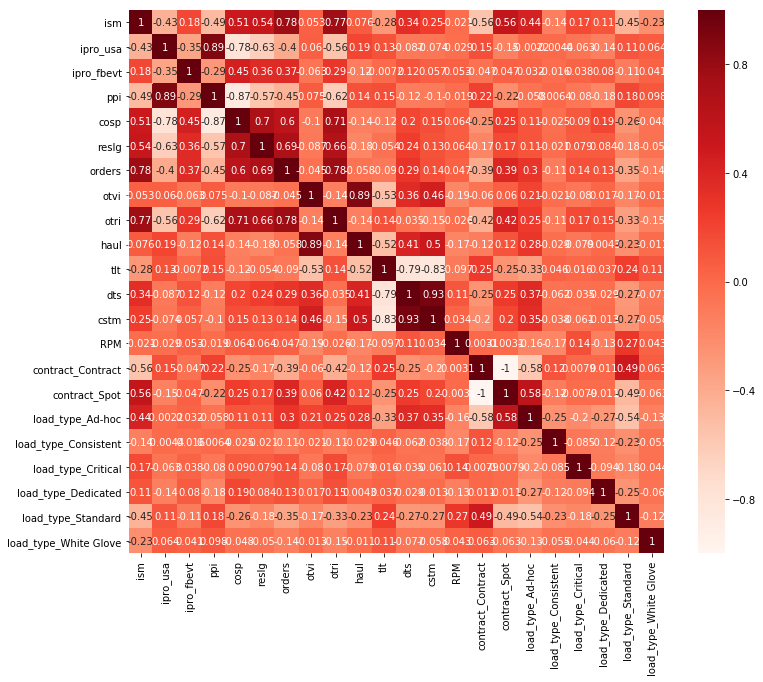

In [233]:
#Using Pearson Correlation
fig22=plt.figure(figsize=(12,10))
cor = short_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [234]:
cor_target = abs(cor['RPM'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

otvi                    0.187456
haul                    0.167770
dts                     0.107511
RPM                     1.000000
load_type_Ad-hoc        0.160125
load_type_Consistent    0.174583
load_type_Critical      0.141500
load_type_Dedicated     0.133874
load_type_Standard      0.274969
Name: RPM, dtype: float64

Nothing is very highly correlated with RPM, the dependent variable. However, certain independent variables are highly correlated with one another.

### Recursive Feature Elimination

In [235]:
y_ext = short_df.loc[:, short_df.columns == 'RPM']
X_ext = short_df.iloc[:,0:13]

In [236]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 3)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_ext,y_ext)  

#Fitting the data to model
model.fit(X_rfe,y_ext)
print(rfe.support_)
print(rfe.ranking_)

[False False  True False False False False False False False  True  True
 False]
[ 3  8  1  4 11  2 10  6  5  7  1  1  9]


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [237]:
X_ext.columns

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm'],
      dtype='object')

#### RFE selects IPRO_FBEVT, TLT, and DTS when given only external factors

In [239]:
y = short_df.loc[:, short_df.columns == 'RPM']
X = short_df.loc[:, short_df.columns != 'RPM']

In [240]:
#no of features
nof_list=np.arange(1,23)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

Optimum number of features: 21
Score with 21 features: 0.282923


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

In [241]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 21)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm', 'contract_Contract',
       'contract_Spot', 'load_type_Ad-hoc', 'load_type_Consistent',
       'load_type_Critical', 'load_type_Dedicated', 'load_type_Standard',
       'load_type_White Glove'],
      dtype='object')


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Quick Linear Regression Model

In [242]:
predictors=['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm', 'contract_Contract',
       'contract_Spot', 'load_type_Ad-hoc', 'load_type_Consistent',
       'load_type_Critical', 'load_type_Dedicated', 'load_type_Standard',
       'load_type_White Glove']
X_s=X[predictors]
y_s=y['RPM']

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=0)

In [244]:
model = LinearRegression()
result=model.fit(X_train,y_train)

In [245]:
print(model.intercept_)

-19.111272393837694


In [246]:
print(model.coef_)

[-6.22095230e-02 -1.61880611e-02 -1.67935603e-02  1.38125921e-01
  2.27666126e-05 -1.16712545e-02  1.66531111e-05 -1.46775924e-02
  2.26519684e-03  4.57832823e-03 -2.08045791e+00  1.74492175e+00
 -1.09856138e-04 -3.68357603e-01  3.68357603e-01 -1.03017882e+00
 -1.01133750e+00  9.65378190e-01 -8.48032922e-01  1.11690356e+00
  8.07267482e-01]


In [247]:
y_pred = model.predict(X_test)

In [248]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.head()

Actual  Predicted
70686  5.087391   4.298865
55693  5.420800   5.363551
44455  4.832811   4.997501
15119  4.565351   4.013050
35064  2.505495   3.312041

In [249]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.1082622280278869
Mean Squared Error: 2.6166556949381303
Root Mean Squared Error: 1.6176080164669469


In [250]:
model.score(X_test,y_test)

0.27727080867758136

### Middle Distance

In [251]:
mid_df=new_df[new_df['dist']=='M']

In [252]:
mid_df=mid_df.drop(columns=['datvf','orail53l','intrm','date','dist']).dropna()

In [253]:
mid_df=pd.get_dummies(mid_df, prefix=['contract', 'load_type'])

In [254]:
mid_df.head()

ism  ipro_usa  ipro_fbevt    ppi      cosp  reslg   orders   otvi  \
123  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  190.9   
175  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  200.6   
188  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  198.4   
193  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  199.2   
199  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  204.6   

      otri  haul  ...      cstm       RPM  contract_Contract  contract_Spot  \
123  28.16  32.9  ...      2.43  2.311047                  0              1   
175  27.17  41.0  ...      3.29  1.356132                  0              1   
188   9.81  48.0  ...  11143.57  2.516779                  0              1   
193   9.41  43.6  ...  13676.14  1.393168                  0              1   
199  27.66  51.0  ...      3.86  2.050511                  0              1   

     load_type_Ad-hoc  load_type_Consistent  load_type_Critical  \
123                 1                     0                   0   
175                 1                     0                   0   
188                 1                     0                   0   
193                 1                     0                   0   
199                 0                     0                   0   

     load_type_Dedicated  load_type_Standard  load_type_White Glove  
123                    0                   0                      0  
175                    0                   0                      0  
188                    0                   0                      0  
193                    0                   0                      0  
199                    1                   0                      0  

[5 rows x 22 columns]

### Correlation Matrix

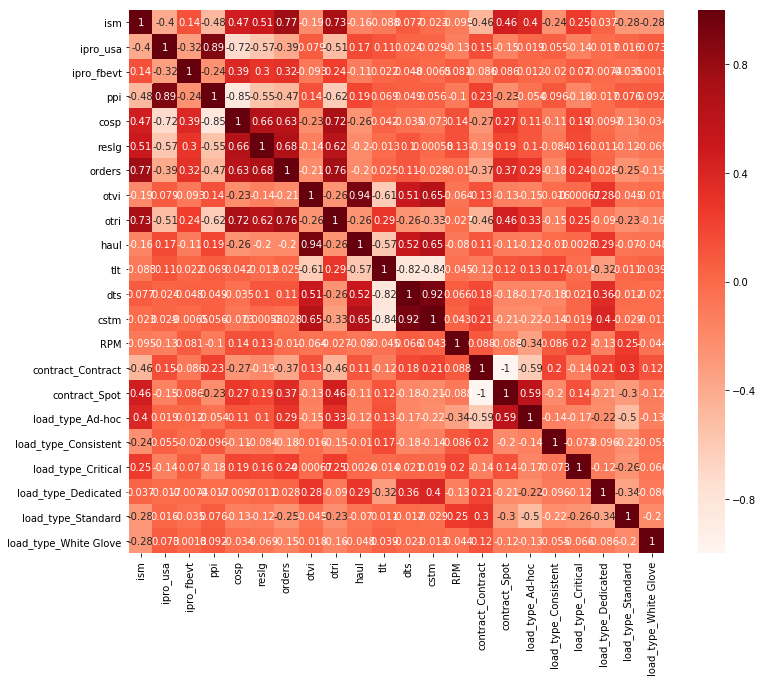

In [255]:
#Using Pearson Correlation
fig23=plt.figure(figsize=(12,10))
cor = mid_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [256]:
cor_target = abs(cor['RPM'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

RPM                   1.000000
load_type_Ad-hoc      0.339379
load_type_Critical    0.202442
load_type_Standard    0.252155
Name: RPM, dtype: float64

Nothing is very highly correlated with RPM, the dependent variable. However, certain independent variables are highly correlated with one another.

### Recursive Feature Elimination

In [257]:
y_ext = mid_df.loc[:, mid_df.columns == 'RPM']
X_ext = mid_df.iloc[:,0:13]

In [258]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 3)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_ext,y_ext)  

#Fitting the data to model
model.fit(X_rfe,y_ext)
print(rfe.support_)
print(rfe.ranking_)

[False  True False False False False False False False False  True  True
 False]
[ 3  1  4  5 10  2 11  7  6  8  1  1  9]


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [259]:
X_ext.columns

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm'],
      dtype='object')

#### RFE selects IPRO_USA, TLT, and DTS when given only external factors

In [260]:
y = mid_df.loc[:, mid_df.columns == 'RPM']
X = mid_df.loc[:, mid_df.columns != 'RPM']

In [261]:
#no of features
nof_list=np.arange(1,23)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

Optimum number of features: 21
Score with 21 features: 0.254474


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [262]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 21)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm', 'contract_Contract',
       'contract_Spot', 'load_type_Ad-hoc', 'load_type_Consistent',
       'load_type_Critical', 'load_type_Dedicated', 'load_type_Standard',
       'load_type_White Glove'],
      dtype='object')


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Quick Linear Regression Model

In [263]:
predictors=['ipro_usa', 'tlt', 'dts', 'cstm', 'contract_Contract',
       'contract_Spot', 'load_type_Ad-hoc', 'load_type_Consistent',
       'load_type_Critical', 'load_type_Dedicated', 'load_type_Standard',
       'load_type_White Glove']
X_s=X[predictors]
y_s=y['RPM']

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=0)

In [265]:
model = LinearRegression()
result=model.fit(X_train,y_train)

In [266]:
print(model.intercept_)

14.045542297992203


In [267]:
print(model.coef_)

[-1.23797883e-01  6.91189460e-02  7.79996769e-01 -2.23469486e-05
 -1.17879348e-01  1.17879348e-01 -8.76425881e-01  5.95652160e-01
  6.49318535e-01 -5.02832422e-01  3.24207467e-01 -1.89919860e-01]


In [268]:
y_pred = model.predict(X_test)

In [269]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.head()

Actual  Predicted
34361  2.201359   2.395781
19189  2.764444   2.552701
50611  2.735158   3.594128
52354  2.364302   2.261746
69219  6.559683   3.667582

In [270]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.7304048233015126
Mean Squared Error: 1.4187274594507928
Root Mean Squared Error: 1.1911034629497106


In [271]:
model.score(X_test,y_test)

0.2159396901957584

### Tweener Distance

In [272]:
tween_df=new_df[new_df['dist']=='T']

In [273]:
tween_df.head()

date dist contract   load_type   ism  ipro_usa  ipro_fbevt    ppi  \
133 2018-03-13    T     Spot      Ad-hoc  60.7    106.64      110.52  143.5   
136 2018-03-15    T     Spot      Ad-hoc  60.7    106.64      110.52  143.5   
139 2018-03-15    T     Spot  Consistent  60.7    106.64      110.52  143.5   
140 2018-03-16    T     Spot      Ad-hoc  60.7    106.64      110.52  143.5   
142 2018-03-16    T     Spot      Ad-hoc  60.7    106.64      110.52  143.5   

         cosp  reslg  ...   otvi   otri  haul   tlt    dts  cstm  datvf  \
133  577315.0   4.78  ...  190.9  28.16  32.9  2.57  2.915  2.43    NaN   
136  577315.0   4.78  ...  446.8  19.77 -77.3  2.31  2.777   NaN    NaN   
139  577315.0   4.78  ...  446.8  19.77 -77.3  2.31  2.777   NaN    NaN   
140  577315.0   4.78  ...  449.7  19.83 -77.3  2.34  2.783   NaN    NaN   
142  577315.0   4.78  ...  449.7  19.83 -77.3  2.34  2.783   NaN    NaN   

     orail53l  intrm       RPM  
133       NaN    NaN  1.651982  
136       NaN    NaN  3.193277  
139       NaN    NaN  2.478992  
140       NaN    NaN  3.193277  
142       NaN    NaN  3.193277  

[5 rows x 21 columns]

In [274]:
tween_nonlane=tween_df[tween_df['datvf'].isna()]

In [275]:
tween_lane=tween_df[tween_df['datvf'].notna()]

In [276]:
tween_nonlane=tween_nonlane.drop(columns=['datvf','orail53l','intrm','date','dist']).dropna()

In [277]:
tween_nonlane=pd.get_dummies(tween_nonlane, prefix=['contract', 'load_type'])

In [278]:
tween_nonlane.head()

ism  ipro_usa  ipro_fbevt    ppi      cosp  reslg   orders   otvi  \
133  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  190.9   
159  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  201.2   
164  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  200.9   
173  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  197.0   
197  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  204.6   

      otri  haul  ...  cstm       RPM  contract_Contract  contract_Spot  \
133  28.16  32.9  ...  2.43  1.651982                  0              1   
159  26.82  42.4  ...  3.29  1.319876                  0              1   
164  26.87  42.1  ...  3.29  2.623211                  0              1   
173  26.90  37.9  ...  3.43  0.889968                  0              1   
197  27.66  51.0  ...  3.86  0.324219                  0              1   

     load_type_Ad-hoc  load_type_Consistent  load_type_Critical  \
133                 1                     0                   0   
159                 1                     0                   0   
164                 1                     0                   0   
173                 1                     0                   0   
197                 1                     0                   0   

     load_type_Dedicated  load_type_Standard  load_type_White Glove  
133                    0                   0                      0  
159                    0                   0                      0  
164                    0                   0                      0  
173                    0                   0                      0  
197                    0                   0                      0  

[5 rows x 22 columns]

### Correlation Matrix

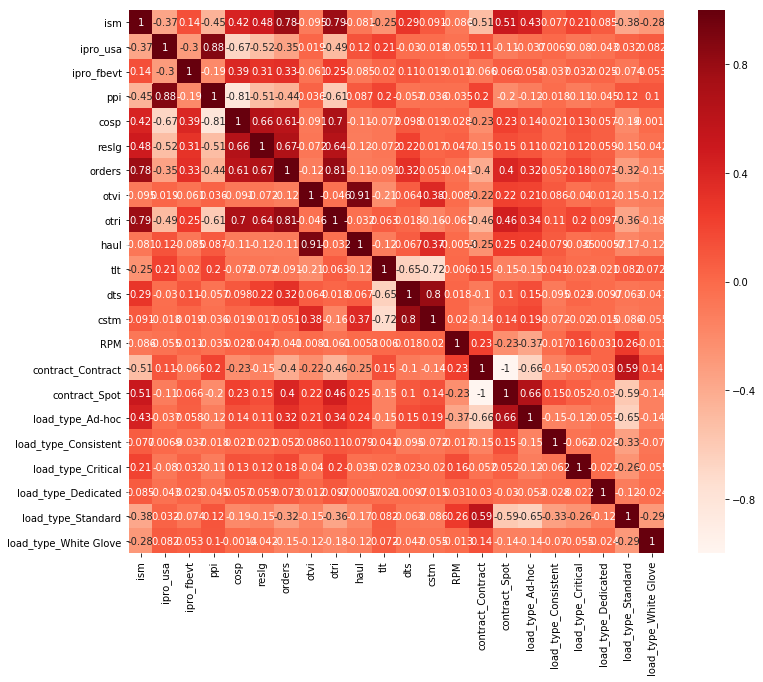

In [279]:
#Using Pearson Correlation
fig24=plt.figure(figsize=(12,10))
cor = tween_nonlane.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [280]:
cor_target = abs(cor['RPM'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

RPM                   1.000000
contract_Contract     0.233457
contract_Spot         0.233457
load_type_Ad-hoc      0.372558
load_type_Standard    0.257882
Name: RPM, dtype: float64

Nothing is very highly correlated with RPM, the dependent variable. However, certain independent variables are highly correlated with one another.

### Recursive Feature Elimination

In [281]:
y_ext = tween_nonlane.loc[:, tween_nonlane.columns == 'RPM']
X_ext = tween_nonlane.iloc[:,0:13]

In [282]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 3)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_ext,y_ext)  

#Fitting the data to model
model.fit(X_rfe,y_ext)
print(rfe.support_)
print(rfe.ranking_)

[False  True False False False False False False False False  True  True
 False]
[ 5  1  6  2 11  3 10  8  4  7  1  1  9]


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [283]:
X_ext.columns

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm'],
      dtype='object')

#### RFE selects IPRO_USA, TLT, and DTS when given only external factors

In [284]:
y = tween_nonlane.loc[:, tween_nonlane.columns == 'RPM']
X = tween_nonlane.loc[:, tween_nonlane.columns != 'RPM']

In [285]:
len(tween_nonlane.columns)

22

#### RFE selects all Load Type categorical variables

In [286]:
#no of features
nof_list=np.arange(1,23)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

Optimum number of features: 21
Score with 21 features: 0.177112


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

In [287]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 21)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm', 'contract_Contract',
       'contract_Spot', 'load_type_Ad-hoc', 'load_type_Consistent',
       'load_type_Critical', 'load_type_Dedicated', 'load_type_Standard',
       'load_type_White Glove'],
      dtype='object')


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Quick Linear Regression Model

In [288]:
predictors=['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm', 'contract_Contract',
       'contract_Spot', 'load_type_Ad-hoc', 'load_type_Consistent',
       'load_type_Critical', 'load_type_Dedicated', 'load_type_Standard',
       'load_type_White Glove']
X_s=X[predictors]
y_s=y['RPM']

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=0)

In [290]:
model = LinearRegression()
result=model.fit(X_train,y_train)

In [291]:
print(model.intercept_)

-0.6645930093913814


In [292]:
print(model.coef_)

[ 2.41424782e-02  1.72348019e-02  8.95686807e-03 -1.54381303e-02
  2.31686048e-06  4.91929166e-02  2.26218705e-06 -3.91597549e-04
 -1.38037997e-02  3.72182856e-03  1.68573060e-01 -1.86463642e-01
  2.63283673e-05  1.85152918e-02 -1.85152918e-02 -7.82555045e-01
 -1.14867957e-01  5.36097717e-01  1.56147817e-01  1.82426947e-01
  2.27505198e-02]


In [293]:
y_pred = model.predict(X_test)

In [294]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.head()

Actual  Predicted
79879  2.333952   2.637118
24916  2.502703   1.803950
79958  3.573630   2.276795
62854  1.720815   2.477081
19222  3.937878   3.173078

In [295]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.5402886492701071
Mean Squared Error: 0.7387803838206866
Root Mean Squared Error: 0.8595233468735369


In [296]:
model.score(X_test,y_test)

0.18026232241850182

### Long Distance

In [297]:
long_df=new_df[new_df['dist']=='L']

In [298]:
long_df.head()

date dist contract load_type   ism  ipro_usa  ipro_fbevt    ppi  \
52  2018-03-20    L     Spot    Ad-hoc  60.7    106.64      110.52  143.5   
105 2018-03-13    L     Spot    Ad-hoc  60.7    106.64      110.52  143.5   
117 2018-03-13    L     Spot    Ad-hoc  60.7    106.64      110.52  143.5   
121 2018-03-13    L     Spot    Ad-hoc  60.7    106.64      110.52  143.5   
122 2018-03-13    L     Spot    Ad-hoc  60.7    106.64      110.52  143.5   

         cosp  reslg  ...   otvi   otri  haul   tlt    dts     cstm  datvf  \
52   577315.0   4.78  ...  203.3  10.48  50.0  2.04  3.589  6389.29    NaN   
105  577315.0   4.78  ...  190.9  28.16  32.9  2.57  2.915     2.43    NaN   
117  577315.0   4.78  ...  242.6  14.86  16.3  2.57  2.630      NaN  1.261   
121  577315.0   4.78  ...  190.9  28.16  32.9  2.57  2.915     2.43    NaN   
122  577315.0   4.78  ...  190.9  28.16  32.9  2.57  2.915     2.43    NaN   

     orail53l  intrm       RPM  
52        NaN    NaN  1.397843  
105       NaN    NaN  1.784434  
117    362.71   1.04  0.965402  
121       NaN    NaN  0.142822  
122       NaN    NaN  1.695906  

[5 rows x 21 columns]

In [299]:
long_nonlane=long_df[long_df['datvf'].isna()]

In [300]:
long_lane=long_df[long_df['datvf'].notna()]

In [301]:
long_nonlane=long_nonlane.drop(columns=['datvf','orail53l','intrm','date','dist']).dropna()

In [302]:
long_nonlane=pd.get_dummies(long_nonlane, prefix=['contract', 'load_type'])

In [303]:
long_nonlane.head()

ism  ipro_usa  ipro_fbevt    ppi      cosp  reslg   orders   otvi  \
52   60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  203.3   
105  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  190.9   
121  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  190.9   
122  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  190.9   
124  60.7    106.64      110.52  143.5  577315.0   4.78  33071.0  194.5   

      otri  haul  ...     cstm       RPM  contract_Contract  contract_Spot  \
52   10.48  50.0  ...  6389.29  1.397843                  0              1   
105  28.16  32.9  ...     2.43  1.784434                  0              1   
121  28.16  32.9  ...     2.43  0.142822                  0              1   
122  28.16  32.9  ...     2.43  1.695906                  0              1   
124  28.29  39.3  ...     2.43  1.368778                  0              1   

     load_type_Ad-hoc  load_type_Consistent  load_type_Critical  \
52                  1                     0                   0   
105                 1                     0                   0   
121                 1                     0                   0   
122                 1                     0                   0   
124                 1                     0                   0   

     load_type_Dedicated  load_type_Standard  load_type_White Glove  
52                     0                   0                      0  
105                    0                   0                      0  
121                    0                   0                      0  
122                    0                   0                      0  
124                    0                   0                      0  

[5 rows x 22 columns]

### Correlation Matrix

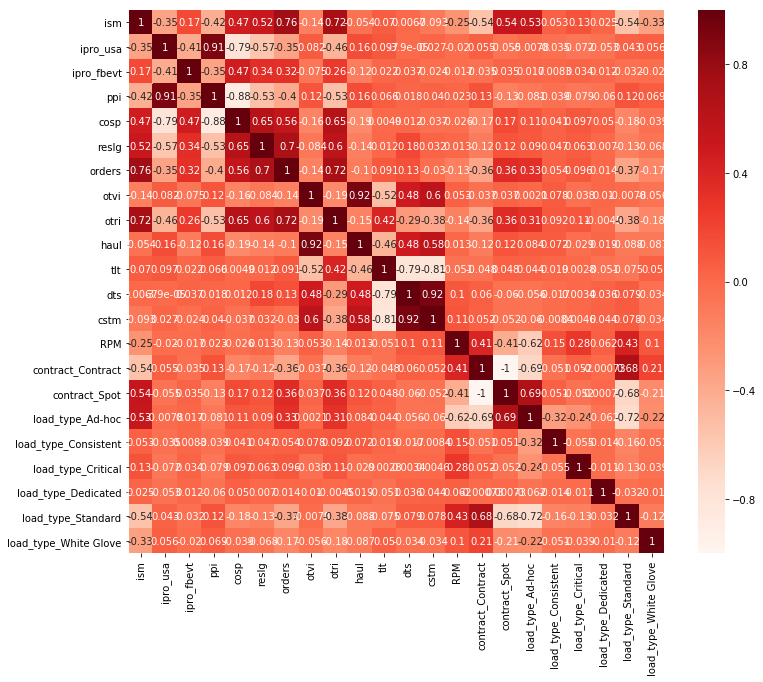

In [304]:
#Using Pearson Correlation
fig25=plt.figure(figsize=(12,10))
cor = long_nonlane.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [305]:
cor_target = abs(cor['RPM'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

RPM                   1.000000
contract_Contract     0.411527
contract_Spot         0.411527
load_type_Ad-hoc      0.618556
load_type_Standard    0.428614
Name: RPM, dtype: float64

In [306]:
print(long_nonlane[['contract_Contract','contract_Spot','load_type_Ad-hoc','load_type_Standard']].corr())

                    contract_Contract  contract_Spot  load_type_Ad-hoc  \
contract_Contract            1.000000      -1.000000         -0.687284   
contract_Spot               -1.000000       1.000000          0.687284   
load_type_Ad-hoc            -0.687284       0.687284          1.000000   
load_type_Standard           0.683904      -0.683904         -0.722630   

                    load_type_Standard  
contract_Contract             0.683904  
contract_Spot                -0.683904  
load_type_Ad-hoc             -0.722630  
load_type_Standard            1.000000  


Some variables are correlated highly with RPM, the dependent variable. However, these independent variables are highly correlated with one another.

### Recursive Feature Elimination

In [307]:
y_ext = long_nonlane.loc[:, long_nonlane.columns == 'RPM']
X_ext = long_nonlane.iloc[:,0:13]

In [308]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 3)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_ext,y_ext)  

#Fitting the data to model
model.fit(X_rfe,y_ext)
print(rfe.support_)
print(rfe.ranking_)

[False  True False False False False False False False False  True  True
 False]
[ 2  1  4  5 11  3 10  8  6  7  1  1  9]


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [309]:
X_ext.columns

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm'],
      dtype='object')

#### RFE selects IPRO_USA, TLT, and DTS when given only external factors

In [310]:
y = long_nonlane.loc[:, long_nonlane.columns == 'RPM']
X = long_nonlane.loc[:, long_nonlane.columns != 'RPM']

In [311]:
len(long_nonlane.columns)

22

#### RFE selects all Load Type categorical variables

In [312]:
#no of features
nof_list=np.arange(1,23)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

Optimum number of features: 21
Score with 21 features: 0.413661


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

In [313]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 21)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm', 'contract_Contract',
       'contract_Spot', 'load_type_Ad-hoc', 'load_type_Consistent',
       'load_type_Critical', 'load_type_Dedicated', 'load_type_Standard',
       'load_type_White Glove'],
      dtype='object')


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Quick Linear Regression Model

In [314]:
predictors=['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm', 'contract_Contract',
       'contract_Spot', 'load_type_Ad-hoc', 'load_type_Consistent',
       'load_type_Critical', 'load_type_Dedicated', 'load_type_Standard',
       'load_type_White Glove']
X_l=X[predictors]
y_l=y['RPM']

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X_l, y_l, test_size=0.2, random_state=0)

In [316]:
model = LinearRegression()
result=model.fit(X_train,y_train)

In [317]:
print(model.intercept_)

4.877127749726812


In [318]:
print(model.coef_)

[ 1.73328994e-02 -1.34013956e-02 -3.17816293e-02  5.85289829e-03
  2.46046756e-07  2.86669311e-02  1.21818584e-06  1.43469164e-05
 -1.39189527e-03  1.10384440e-03  2.20474507e-01 -1.88550163e-01
  2.51422581e-05  2.46668837e-03 -2.46668837e-03 -1.01962291e+00
 -1.20477147e-01  5.50512604e-01  4.11644228e-01  1.26253938e-01
  5.16892877e-02]


In [319]:
y_pred = model.predict(X_test)

In [320]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.head()

Actual  Predicted
24578  1.098901   0.955623
74703  1.683507   2.073363
31087  1.360794   1.109989
57640  3.061144   2.282348
40474  1.169749   1.023224

In [321]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.4930823579115231
Mean Squared Error: 0.4129816601883584
Root Mean Squared Error: 0.6426364914851618


In [322]:
model.score(X_test,y_test)

0.41435149367002055

## Lanes

In [323]:
df=pred_df.dropna()

In [324]:
len(df)

1454

In [325]:
df=df.drop(columns=['date','dist'])

In [326]:
df=pd.get_dummies(df, prefix=['contract', 'load_type'])

In [327]:
df.head()

ism  ipro_usa  ipro_fbevt    ppi      cosp  reslg   orders   otvi  \
343  59.3    107.25      109.44  143.6  562170.0   4.92  38691.0  191.1   
377  57.9    108.22      110.50  143.9  564480.0   4.66  27026.0  206.0   
453  57.9    108.22      110.50  143.9  564480.0   4.66  27026.0  207.0   
642  58.7    107.36      109.84  145.6  562939.0   6.46  27823.0  217.3   
643  58.7    107.36      109.84  145.6  562939.0   6.46  27823.0  211.0   

      otri  haul  ...  intrm       RPM  contract_Contract  contract_Spot  \
343  19.94  33.4  ...   2.15  0.737179                  0              1   
377   7.62  53.0  ...   2.95  1.497504                  0              1   
453  22.43  33.8  ...   2.08  1.001369                  0              1   
642  26.14  43.4  ...   2.17  1.394483                  0              1   
643  25.86  38.2  ...   2.17  1.394483                  0              1   

     load_type_Ad-hoc  load_type_Consistent  load_type_Critical  \
343                 1                     0                   0   
377                 1                     0                   0   
453                 1                     0                   0   
642                 1                     0                   0   
643                 1                     0                   0   

     load_type_Dedicated  load_type_Standard  load_type_White Glove  
343                    0                   0                      0  
377                    0                   0                      0  
453                    0                   0                      0  
642                    0                   0                      0  
643                    0                   0                      0  

[5 rows x 25 columns]

In [328]:
y = df.loc[:, df.columns == 'RPM']
X = df.loc[:, df.columns != 'RPM']

### Correlation Matrix

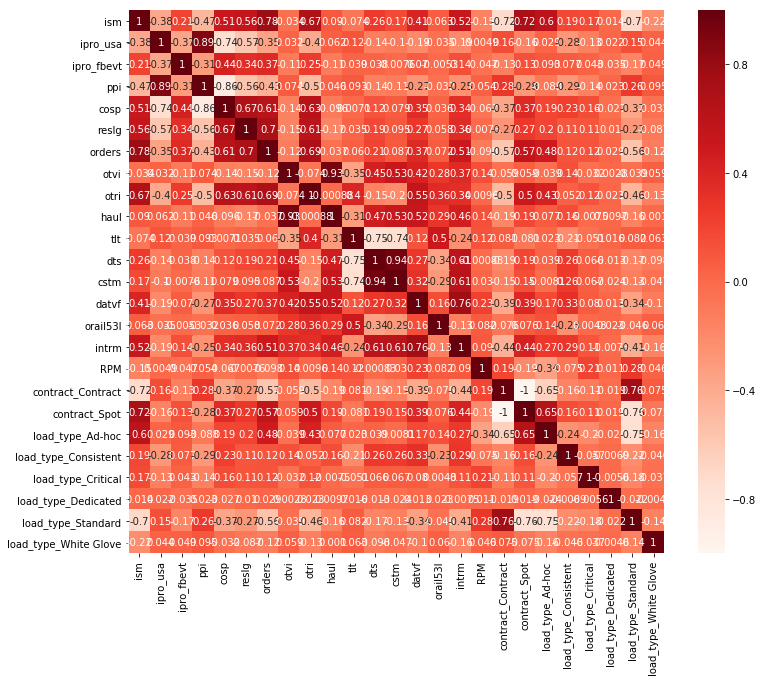

In [329]:
#Using Pearson Correlation
fig26=plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [330]:
cor_target = abs(cor['RPM'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

datvf                 0.225417
RPM                   1.000000
load_type_Ad-hoc      0.339459
load_type_Critical    0.208818
load_type_Standard    0.278811
Name: RPM, dtype: float64

Nothing is very highly correlated with RPM, the dependent variable. However, certain independent variables are highly correlated with one another.

### Recursive Feature Elimination

In [331]:
y_ext = df.loc[:, df.columns == 'RPM']
X_ext = df.iloc[:,0:16]

In [332]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 3)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_ext,y_ext)  

#Fitting the data to model
model.fit(X_rfe,y_ext)
print(rfe.support_)
print(rfe.ranking_)

[False  True False False False False False False False False  True False
 False  True False False]
[ 4  1  5  2 12  7 14 10  8  9  1  3 13  1 11  6]


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [333]:
X_ext.columns

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'orders',
       'otvi', 'otri', 'haul', 'tlt', 'dts', 'cstm', 'datvf', 'orail53l',
       'intrm'],
      dtype='object')

#### RFE selects IPRO_USA, DATVF, and TLT when given only external factors

In [334]:
y = df.loc[:, df.columns == 'RPM']
X = df.loc[:, df.columns != 'RPM']

In [335]:
len(X.columns)

24

#### RFE selects all Load Type categorical variables

In [336]:
#no of features
nof_list=np.arange(1,25)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when 

Optimum number of features: 23
Score with 23 features: 0.349902


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [337]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 23)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'otvi', 'otri',
       'haul', 'tlt', 'dts', 'cstm', 'datvf', 'orail53l', 'intrm',
       'contract_Contract', 'contract_Spot', 'load_type_Ad-hoc',
       'load_type_Consistent', 'load_type_Critical', 'load_type_Dedicated',
       'load_type_Standard', 'load_type_White Glove'],
      dtype='object')


/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Quick Linear Regression Model

In [338]:
predictors=['ism', 'ipro_usa', 'ipro_fbevt', 'ppi', 'cosp', 'reslg', 'otvi', 'otri',
       'haul', 'tlt', 'dts', 'cstm', 'datvf', 'orail53l', 'intrm',
       'contract_Contract', 'contract_Spot', 'load_type_Ad-hoc',
       'load_type_Consistent', 'load_type_Critical', 'load_type_Dedicated',
       'load_type_Standard', 'load_type_White Glove']
X_l=X[predictors]
y_l=y['RPM']

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X_l, y_l, test_size=0.2, random_state=0)

In [340]:
model = LinearRegression()
result=model.fit(X_train,y_train)

In [341]:
print(model.intercept_)

11.038914675026206


In [342]:
print(model.coef_)

[ 1.01528548e-02 -1.17674091e-01  3.28223348e-02  2.12393516e-02
 -8.92946529e-06  6.28167559e-02 -3.77410200e-03  8.81422060e-04
  5.80001184e-03 -5.33982303e-02  3.65896572e-02 -1.65162119e-05
  8.89783120e-01 -1.86747703e-04 -2.29038126e-02 -2.08778595e-02
  2.08778595e-02 -7.60103152e-01 -1.20241551e+00  9.75415811e-01
 -1.99148284e-01  5.32238353e-01  6.54012785e-01]


In [343]:
y_pred = model.predict(X_test)

In [344]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.head()

Actual  Predicted
30775  1.460916   1.571897
91685  2.279889   2.638546
83040  1.660170   1.522653
29778  1.601638   1.623820
71735  3.257304   2.611654

In [345]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.4219851166822101
Mean Squared Error: 0.5910298703218209
Root Mean Squared Error: 0.7687846709721916


In [346]:
model.score(X_test,y_test)

0.43899326044507175

## Question 6

    What other insights can you provide a shipper based on these data sets?